In [1]:
!pip install datasets transformers
!pip install fvcore
!pip install -U zetascale

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 474.3/474.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 39.9/39.9 MB 20.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
  Attempting uninstall: pyarrow
    Found existing installation: pyarrow 14.0.2
    Uninstalling pyarrow-14.0.2:
      Successfully uninstalled pyarrow-14.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
cudf-cu12 24.4.1 requires pyarrow<15.0.0a0,>=14.0.1, but you have pyarrow 17.0.0 which is incompatible.
ibis-framework 8.0.0 requires pyarrow<16,>=2, but you have pyarrow 17.0.0 which is incompatible.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.1 

In [1]:
import torch
import torch.nn.functional as F
from torch import Tensor, nn
import subprocess
import time
import matplotlib.pyplot as plt
from zeta.nn import *  # noqa: F403, E402
from fvcore.nn import FlopCountAnalysis, flop_count

from zeta.nn import FeedForward, MultiQueryAttention

avg_power = [0] * 3
avg_flops = [0] * 3
num_passes= 0

class SwitchGate(nn.Module):
    """
    SwitchGate module for MoE (Mixture of Experts) model.

    Args:
        dim (int): Input dimension.
        num_experts (int): Number of experts.
        capacity_factor (float, optional): Capacity factor for sparsity. Defaults to 1.0.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.
    """

    def __init__(
        self,
        dim,
        num_experts: int,
        capacity_factor: float = 1.0,
        epsilon: float = 1e-6,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.num_experts = num_experts
        self.capacity_factor = capacity_factor
        self.epsilon = epsilon
        self.w_gate = nn.Linear(dim, num_experts)

    def forward(self, x: Tensor, use_aux_loss=False):
        """
        Forward pass of the SwitchGate module.

        Args:
            x (Tensor): Input tensor.

        Returns:
            Tensor: Gate scores.
        """
        # Compute gate scores
        gate_scores = F.softmax(self.w_gate(x), dim=-1)
        #print(gate_scores)

        # Determine the top-1 expert for each token
        capacity = int(self.capacity_factor * x.size(0))

        #top_k_scores, top_k_indices = gate_scores.topk(1, dim=-1)

        # # Mask to enforce sparsity
        # #mask = torch.zeros_like(gate_scores).scatter_(
        #     1, top_k_indices, 1
        # )

        # Combine gating scores with the mask
        # masked_gate_scores = gate_scores * mask

        # Denominators
        denominators = (
            gate_scores.sum(0, keepdim=True) + self.epsilon
        )

        # Norm gate scores to sum to the capacity
        gate_scores = (gate_scores / denominators) * capacity

        if use_aux_loss:
            load = gate_scores.sum(0)  # Sum over all examples
            importance = gate_scores.sum(1)  # Sum over all experts

            # Aux loss is mean suqared difference between load and importance
            loss = ((load - importance) ** 2).mean()

            return gate_scores, loss

        return gate_scores, None


class SwitchMoE(nn.Module):
    """
    A module that implements the Switched Mixture of Experts (MoE) architecture.

    Args:
        dim (int): The input dimension.
        hidden_dim (int): The hidden dimension of the feedforward network.
        output_dim (int): The output dimension.
        num_experts (int): The number of experts in the MoE.
        capacity_factor (float, optional): The capacity factor that controls the capacity of the MoE. Defaults to 1.0.
        mult (int, optional): The multiplier for the hidden dimension of the feedforward network. Defaults to 4.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Attributes:
        dim (int): The input dimension.
        hidden_dim (int): The hidden dimension of the feedforward network.
        output_dim (int): The output dimension.
        num_experts (int): The number of experts in the MoE.
        capacity_factor (float): The capacity factor that controls the capacity of the MoE.
        mult (int): The multiplier for the hidden dimension of the feedforward network.
        experts (nn.ModuleList): The list of feedforward networks representing the experts.
        gate (SwitchGate): The switch gate module.


    """
    def get_gpu_power(self):
        # Use nvidia-smi to get the current power draw (in watts)
        try:
            power_info = subprocess.check_output(['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'])
            power_draw = float(power_info.strip())  # Power in watts (W)
            return power_draw
        except Exception as e:
            print("Error getting GPU power:", e)
            return 0

    def __init__(
        self,
        dim: int,
        hidden_dim: int,
        output_dim: int,
        num_experts: int,
        capacity_factor: float = 1.0,
        mult: int = 4,
        use_aux_loss: bool = False,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.num_experts = num_experts
        self.capacity_factor = capacity_factor
        self.mult = mult
        self.use_aux_loss = use_aux_loss
        self.start_time = None
        self.end_time = None
        self.experts = nn.ModuleList(
            [
                FeedForward(dim, dim, mult, *args, **kwargs)
                for _ in range(num_experts)
            ]
        )

        self.gate = SwitchGate(
            dim,
            num_experts,
            capacity_factor,
        )

        self.flops_tracker = torch.zeros(num_experts, dtype=torch.float32)
        self.total_batches = 0
        self.flops_for_batch = {i: 0 for i in range(self.num_experts)}  # FLOPs for the current batch
        self.energy_per_flop = 1e-12

        #self.power_tracker = [0.0] * num_experts

        self.power_tracker = torch.zeros(num_experts, dtype=torch.float32)
        self.flops_per_expert = []
        self.energy_per_expert = []


    def plot_flops_vs_energy(self,total_energy):
      num_experts = len(self.flops_tracker)

    # Compute average FLOPs and energy for each expert
      average_flops_per_expert = self.flops_tracker / self.total_batches


    # Create the plot
      plt.figure(figsize=(10, 6))

    # Plot each expert's FLOPs vs Energy individually
      for i in range(num_experts):
        plt.plot(average_flops_per_expert[i].cpu().numpy(),
                 total_energy[i].cpu().numpy(),
                 'o-', label=f"Expert {i}")

    # Add labels and title
      plt.xlabel("FLOPs (gFLOPs)")
      plt.ylabel("Energy Expenditure (Joules)")
      plt.title("FLOPs vs Energy Expenditure for Each Expert")
      plt.grid(True)
      plt.legend()
      plt.show()

    def forward(self, x: Tensor,energy_data=None):
      gate_scores, loss = self.gate(x)

      initial_power = self.get_gpu_power()


      batch_size, seq_len, num_experts = gate_scores.size()

    # Get the top expert index for each token
      top_k_scores, top_k_indices = gate_scores.topk(1, dim=-1)  # top_k_indices is of shape (batch_size, seq_len, 1)

    # Flatten for easier manipulation
      x_flat = x.view(-1, x.size(-1))  # Flatten to (batch_size * seq_len, dim)
      top_k_indices_flat = top_k_indices.view(-1)  # Flatten to (batch_size * seq_len,)

    # Prepare outputs storage
      selected_expert_outputs = torch.zeros(batch_size * seq_len, x.size(-1), device=x.device)
      expert_weights = torch.zeros(batch_size * seq_len, device=x.device)
      #selected_expert_outputs = torch.zeros_like(x_flat)

      total_flops = torch.zeros(num_experts, device=x.device)
      total_energy = torch.zeros(num_experts, device=x.device)

      total_flops = 0


    # Process each expert independently

      for i in range(num_experts):
        # Get tokens assigned to this expert
        expert_mask = (top_k_indices_flat == i).nonzero(as_tuple=True)[0]
        #expert_mask = torch.arange(x_flat.size(0), device=x.device) #uncomment this line and comment out the above to use K>1

        if expert_mask.numel() > 0:
            tokens_for_expert = x_flat[expert_mask]
            # Compute expert output for these tokens
            self.start_time = time.time()
            expert_output = self.experts[i](tokens_for_expert)
            final_power = self.get_gpu_power()
            self.end_time = time.time()

            total_time= self.end_time - self.start_time

            flops,_ = flop_count(self.experts[i],(tokens_for_expert,))
            expert_flops = sum(flops.values())
            self.flops_tracker[i] += expert_flops

            total_energy[i] += final_power * total_time  # Energy in joules


            # Store the expert output in the corresponding positions
            #selected_expert_outputs.index_add_(0, expert_mask, expert_output)
            weights = top_k_scores.view(-1)[expert_mask]
            expert_weights[expert_mask] = weights.squeeze()

            # Store the expert output in the corresponding positions
            selected_expert_outputs.index_add_(0, expert_mask, expert_output * weights.unsqueeze(1))


    # Reshape the selected expert outputs back to (batch_size, seq_len, dim)
      moe_output = selected_expert_outputs.view(batch_size, seq_len, -1)
      self.total_batches += 1

      average_flops_per_expert = self.flops_tracker / self.total_batches
      avg_energy = total_energy / self.total_batches

      total_energy = total_energy / self.total_batches

      flops_per_layer = 0


      for i in range(num_experts):
         print(f"  Expert {i}: {avg_energy[i]:.4f} J")
         print(f"  Expert {i}: {average_flops_per_expert[i]:.4f} gFlops")
         flops_per_layer += average_flops_per_expert[i]
      self.plot_flops_vs_energy(avg_energy)

      return moe_output, loss,flops_per_layer

#moe_output = torch.stack(expert_outputs, dim=0).sum(dim=0)
class SwitchTransformerBlock(nn.Module):
    """
    SwitchTransformerBlock is a module that represents a single block of the Switch Transformer model.

    Args:
        dim (int): The input dimension of the block.
        heads (int): The number of attention heads.
        dim_head (int): The dimension of each attention head.
        mult (int, optional): The multiplier for the hidden dimension in the feed-forward network. Defaults to 4.
        dropout (float, optional): The dropout rate. Defaults to 0.1.
        depth (int, optional): The number of layers in the block. Defaults to 12.
        num_experts (int, optional): The number of experts in the SwitchMoE layer. Defaults to 6.
        *args: Variable length argument list.
        **kwargs: Arbitrary keyword arguments.

    Attributes:
        dim (int): The input dimension of the block.
        heads (int): The number of attention heads.
        dim_head (int): The dimension of each attention head.
        mult (int): The multiplier for the hidden dimension in the feed-forward network.
        dropout (float): The dropout rate.
        attn_layers (nn.ModuleList): List of MultiQueryAttention layers.
        ffn_layers (nn.ModuleList): List of SwitchMoE layers.

    Examples:
        >>> block = SwitchTransformerBlock(dim=512, heads=8, dim_head=64)
        >>> x = torch.randn(1, 10, 512)
        >>> out = block(x)
        >>> out.shape

    """

    def __init__(
        self,
        dim: int,
        heads: int,
        dim_head: int,
        mult: int = 4,
        dropout: float = 0.1,
        num_experts: int = 3,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        self.mult = mult
        self.dropout = dropout

        self.attn = MultiQueryAttention(
            dim, heads, qk_ln=True * args, **kwargs
        )

        self.ffn = SwitchMoE(
            dim, dim * mult, dim, num_experts, *args, **kwargs
        )

        self.add_norm = nn.LayerNorm(dim)

    def forward(self, x: Tensor):
        """
        Forward pass of the SwitchTransformerBlock.

        Args:
            x (Tensor): The input tensor.

        Returns:
            Tensor: The output tensor.

        """
        resi = x
        x, _, _ = self.attn(x)
        attnflops,_ = flop_count(self.attn,(x,))
        x = x + resi
        x = self.add_norm(x)
        normflops,_ = flop_count(self.add_norm,(x,))
        add_normed = x

        ##### MoE #####
        x, _ ,ffn_flops= self.ffn(x)
        x = x + add_normed
        x = self.add_norm(x)
        total_flops = sum(attnflops.values()) + sum(normflops.values()) + ffn_flops.item()

        return x,total_flops

class LearnedPositionalEmbedding(nn.Module):
    def __init__(self, max_len: int, embed_dim: int):
        super().__init__()
        self.position_embeddings = nn.Embedding(max_len, embed_dim)

    def forward(self, x: Tensor):
        # x is expected to be of shape (batch_size, seq_len)
        batch_size, seq_len = x.size()
        positions = torch.arange(seq_len, device=x.device).unsqueeze(0).expand(batch_size, -1)
        return self.position_embeddings(positions)


class SwitchTransformer(nn.Module):
    """
    SwitchTransformer is a PyTorch module that implements a transformer model with switchable experts.

    Args:
        num_tokens (int): The number of tokens in the input vocabulary.
        dim (int): The dimensionality of the token embeddings and hidden states.
        heads (int): The number of attention heads.
        dim_head (int, optional): The dimensionality of each attention head. Defaults to 64.
        mult (int, optional): The multiplier for the hidden dimension in the feed-forward network. Defaults to 4.
        dropout (float, optional): The dropout rate. Defaults to 0.1.
        num_experts (int, optional): The number of experts in the switchable experts mechanism. Defaults to 3.
        *args: Additional positional arguments.
        **kwargs: Additional keyword arguments.


    """

    def __init__(
        self,
        num_tokens: int,
        dim: int,
        heads: int,
        dim_head: int = 64,
        mult: int = 4,
        dropout: float = 0.1,
        num_experts: int = 3,
        depth: int = 4,
        *args,
        **kwargs,
    ):
        super().__init__()
        self.num_tokens = num_tokens
        self.dim = dim
        self.heads = heads
        self.dim_head = dim_head
        self.mult = mult
        self.dropout = dropout
        self.num_experts = num_experts
        self.depth = depth
        self.sequence_length= 256

        self.embedding = nn.Embedding(num_tokens, dim)
        self.position_embeddings = nn.Embedding(self.sequence_length, dim)
        self.layers = nn.ModuleList([])
        self.start_time = None

        for _ in range(depth):
            self.layers.append(
                SwitchTransformerBlock(
                    dim,
                    heads,
                    dim_head,
                    mult,
                    dropout,
                    num_experts,
                    *args,
                    **kwargs,
                )
            )

        self.to_out = nn.Sequential(
            nn.Softmax(dim=-1),
            nn.LayerNorm(dim),
            nn.Linear(dim, num_tokens),
        )
    def get_gpu_power(self):
        # Use nvidia-smi to get the current power draw (in watts)
        try:

            power_info = subprocess.check_output(['nvidia-smi', '--query-gpu=power.draw', '--format=csv,noheader,nounits'])
            power_draw = float(power_info.strip())  # Power in watts (W)
            return power_draw
        except Exception as e:
            print("Error getting GPU power:", e)
            return 0

    def forward(self, x: Tensor) -> Tensor:
        """
        Forward pass of the SwitchTransformer.

        Args:
            x (Tensor): The input tensor of shape (batch_size, sequence_length).

        Returns:
            Tensor: The output tensor of shape (batch_size, sequence_length, num_tokens).
        """
        # Embed tokens through embedding layer

        x = x.long()




        x = self.embedding(x)

        positions = torch.arange(self.sequence_length, device=x.device).unsqueeze(0).expand(batch_size, -1)
        pEmbed= self.position_embeddings(positions)
        x = x + pEmbed

        flops=[]
        i=1

        initial_power = self.get_gpu_power()

        # Pass through the transformer block with MoE, it's in modulelist
        for layer in self.layers:
            print("Layer ",i)
            i+=1

            self.start_time = time.time()
            x,ffn_flops= layer(x)
            final_power = self.get_gpu_power()
            end_time = time.time()
            elapsed_time = end_time - self.start_time
            energy_in_joules = final_power * elapsed_time
            print("Layer", i , "Energy in joules: ", energy_in_joules)
            flops.append(ffn_flops)



        # Project to output tokens
        x = self.to_out(x)




        for i in range(len(flops)):
              flops_val = flops[i]
              print(f"Layer {i+1} Gflops: {flops_val}")

        return x,flops

In [2]:
!apt-get install git-lfs
!git lfs install
!GIT_LFS_SKIP_SMUDGE=1 git clone https://huggingface.co/datasets/allenai/c4
%cd c4
!git lfs pull --include "en/c4-train.00000-of-01024.json.gz"

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
git-lfs is already the newest version (3.0.2-1ubuntu0.2).
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.
Git LFS initialized.
Cloning into 'c4'...
remote: Enumerating objects: 87108, done.
remote: Total 87108 (delta 0), reused 0 (delta 0), pack-reused 87108 (from 1)
Receiving objects: 100% (87108/87108), 12.30 MiB | 18.76 MiB/s, done.
Resolving deltas: 100% (30/30), done.
Updating files: 100% (69221/69221), done.
/content/c4


In [3]:
from datasets import load_dataset

from transformers import T5TokenizerFast, T5Tokenizer

import gzip
import json

def load_json_gz(filepath):
    with gzip.open(filepath, 'rb') as f:
        for line in f:
            yield json.loads(line)

# Load the small subset you downloaded
dataset_path = 'en/c4-train.00000-of-01024.json.gz'
data = list(load_json_gz(dataset_path))

# Preview a few examples
print(data[:2])

# Load the fast version of the T5 tokenizer
#tokenizer = T5TokenizerFast.from_pretrained("t5-base")
tokenizer = T5Tokenizer.from_pretrained('t5-small', use_fast=True)
# Load the C4 dataset
tokenized_data = [tokenizer.encode(d['text'], return_tensors='pt') for d in data[:100]]

#tokenized_data.set_format(type="torch", columns=["input_ids"])

[{'text': 'Beginners BBQ Class Taking Place in Missoula!\nDo you want to get better at making delicious BBQ? You will have the opportunity, put this on your calendar now. Thursday, September 22nd join World Class BBQ Champion, Tony Balay from Lonestar Smoke Rangers. He will be teaching a beginner level class for everyone who wants to get better with their culinary skills.\nHe will teach you everything you need to know to compete in a KCBS BBQ competition, including techniques, recipes, timelines, meat selection and trimming, plus smoker and fire information.\nThe cost to be in the class is $35 per person, and for spectators it is free. Included in the cost will be either a t-shirt or apron and you will be tasting samples of each meat that is prepared.', 'timestamp': '2019-04-25T12:57:54Z', 'url': 'https://klyq.com/beginners-bbq-class-taking-place-in-missoula/'}, {'text': 'Discussion in \'Mac OS X Lion (10.7)\' started by axboi87, Jan 20, 2012.\nI\'ve got a 500gb internal drive and a 24

tokenizer_config.json:   0%|          | 0.00/2.32k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.39M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Token indices sequence length is longer than the specified maximum sequence length for this model (2600 > 512). Running this sequence through the model will result in indexing errors


100
NUM_TOKENS  32000
Input Text before noise: The Center for the Study of Culture, Politics and Society (CECUPS) is devoted to the sociological analysis of cultural and political subjects, in particular subjects placed in the confluence of those two realms or dimensions of social reality. In this way, and mainly from a comparative perspective, we make research about cultural policy, the relationship between culture and territory, citizenship and the Welfare State, the cultural construction of Europe or the reflexive configuration of modernity. Arturo Rodrguez Morató. Mariano Martn Zamorano. 2018. Cultural Policy in Ibero-America – A Regional Perspective. Taylor & Francis.
Input Text before noise: Yesterday [12 Nov], at the Shoreditch Town Hall, Dr. Macdonald, M.P., the coroner for the North- Eastern District of Middlesex, opened his inquiry relative to the death of Marie Jeanette Kelly, the woman whose body was discovered on Friday morning, terribly mutilated, in a room on the ground 

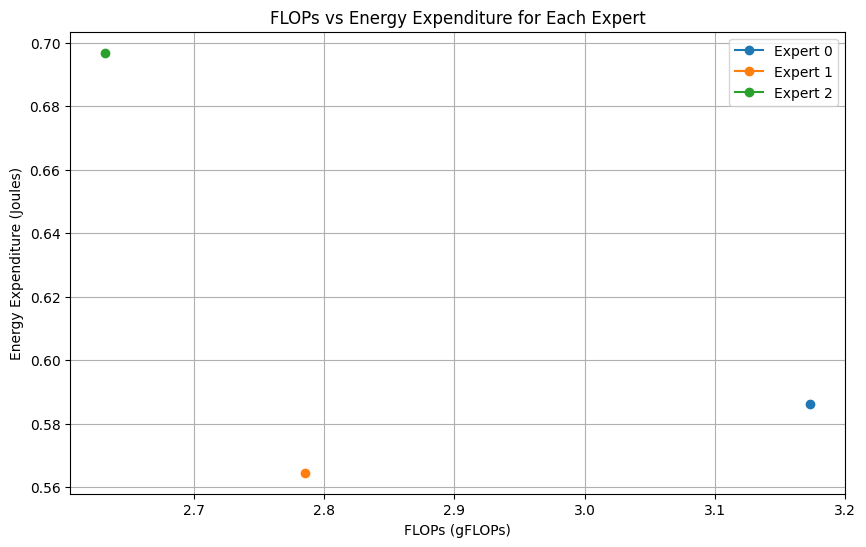

Layer 2 Energy in joules:  12.068010048866272
Layer  2
  Expert 0: 0.6158 J
  Expert 0: 2.6739 gFlops
  Expert 1: 0.6560 J
  Expert 1: 2.6256 gFlops
  Expert 2: 0.6448 J
  Expert 2: 3.2904 gFlops


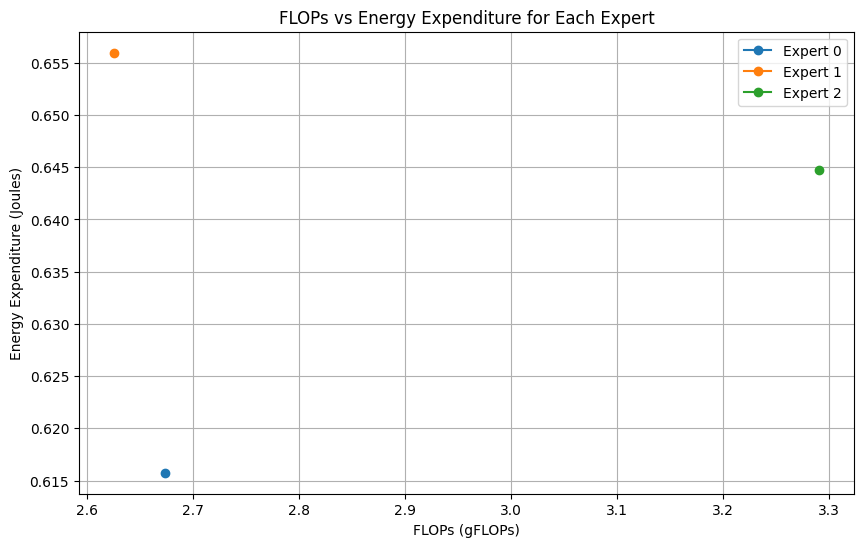

Layer 3 Energy in joules:  12.653486385345458
Layer  3
  Expert 0: 0.6724 J
  Expert 0: 2.7787 gFlops
  Expert 1: 0.6266 J
  Expert 1: 2.4138 gFlops
  Expert 2: 0.8272 J
  Expert 2: 3.3974 gFlops


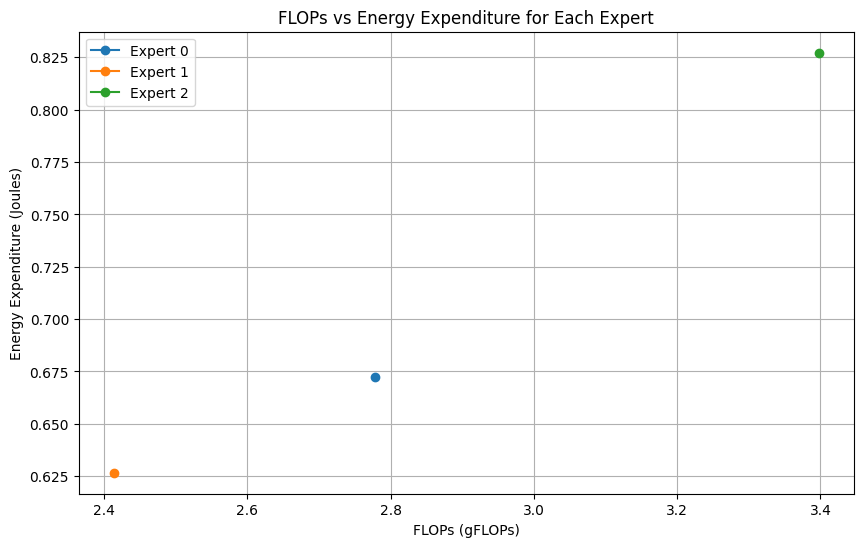

Layer 4 Energy in joules:  12.32700985431671
Layer  4
  Expert 0: 0.6192 J
  Expert 0: 3.1415 gFlops
  Expert 1: 0.6049 J
  Expert 1: 2.8186 gFlops
  Expert 2: 0.6674 J
  Expert 2: 2.6298 gFlops


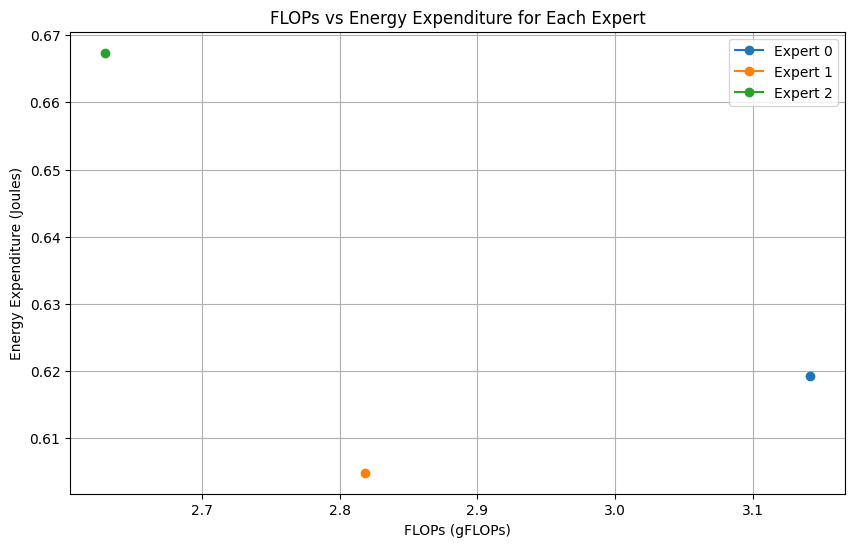

Layer 5 Energy in joules:  11.687173013687133
Layer  5
  Expert 0: 0.8118 J
  Expert 0: 2.6634 gFlops
  Expert 1: 0.6040 J
  Expert 1: 2.7284 gFlops
  Expert 2: 0.7739 J
  Expert 2: 3.1982 gFlops


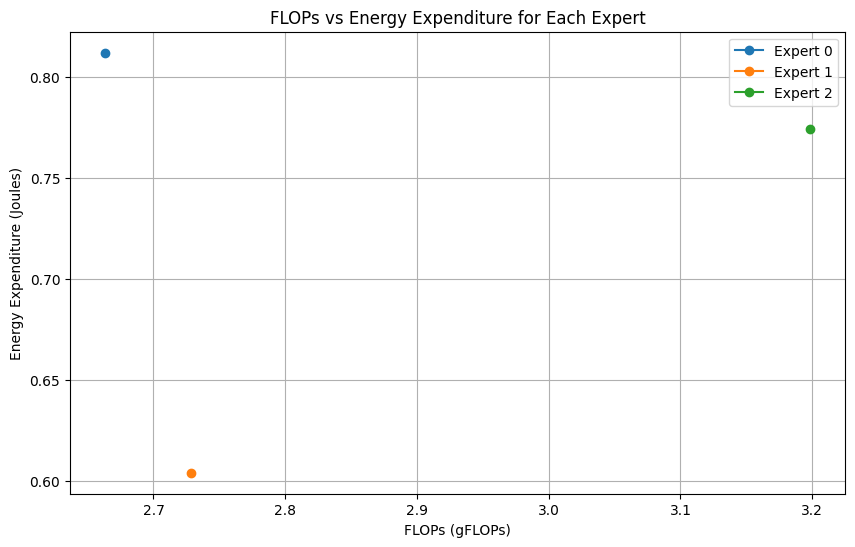

Layer 6 Energy in joules:  11.683399267196656
Layer  6
  Expert 0: 0.5736 J
  Expert 0: 2.6550 gFlops
  Expert 1: 0.6580 J
  Expert 1: 3.0681 gFlops
  Expert 2: 0.6559 J
  Expert 2: 2.8668 gFlops


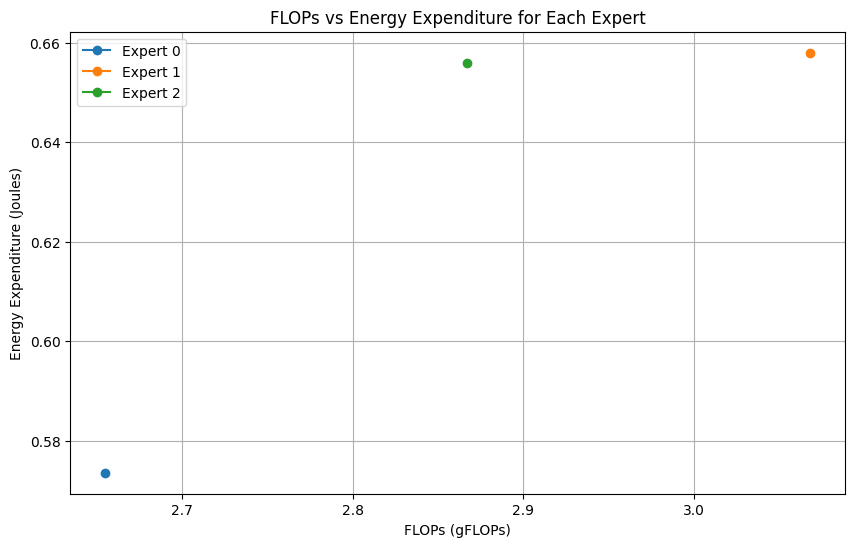

Layer 7 Energy in joules:  11.681622450351716
Layer 1 Gflops: 12.09008103706006
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Input Text before noise: Movers & Moving Companies in Randallsville, New York for every moving service.: Movers MAX :. Movers MAX Movers Directory is your one-stop source for moving resources. Research your move before making that all-important move. Inside, you will find helpful Randallsville, New York moving guides and moving tips on every type of moving services as well as free Randallsville, New York moving estimates from professional movers in Randallsville, New York. With information available on all Randallsville, New York move types you can certainly find out what you need to know about moving anywhere in Randallsville, New York. From local Randallsville, New York moving to long distance moving across 

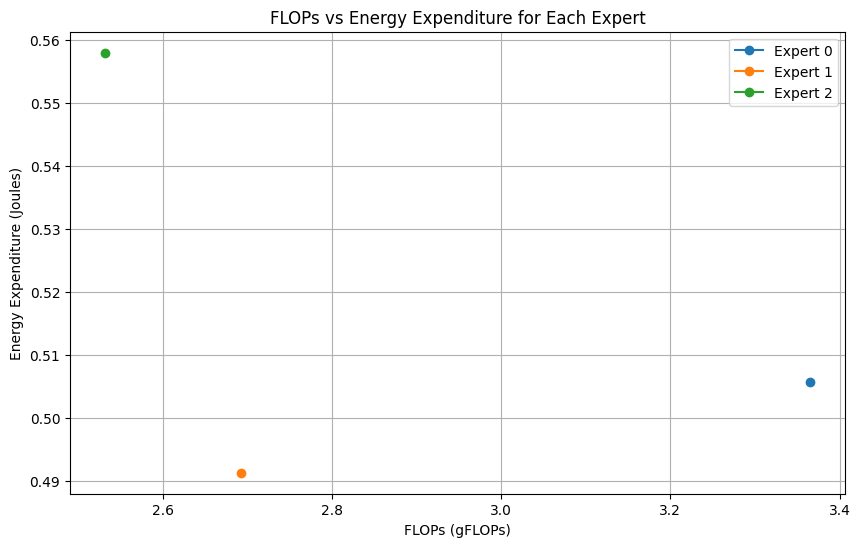

Layer 2 Energy in joules:  16.719098081588747
Layer  2
  Expert 0: 0.5086 J
  Expert 0: 2.8228 gFlops
  Expert 1: 0.4850 J
  Expert 1: 2.5501 gFlops
  Expert 2: 0.4532 J
  Expert 2: 3.2170 gFlops


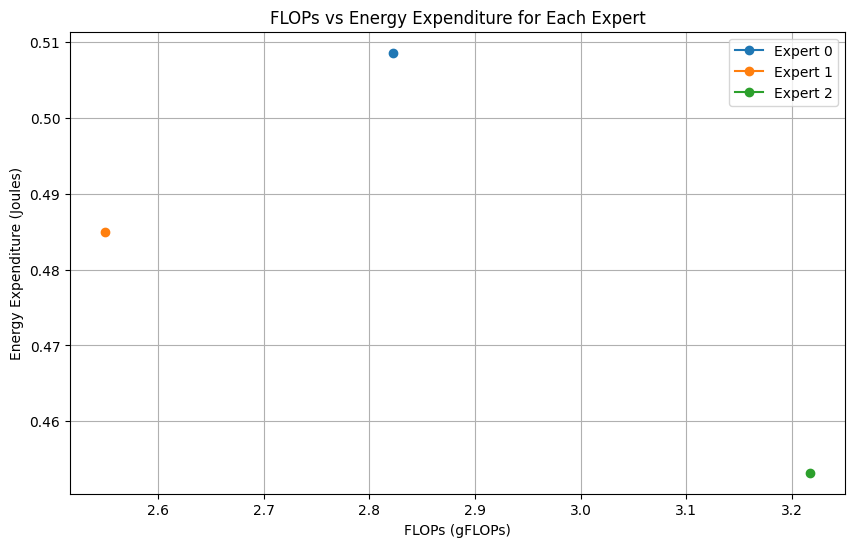

Layer 3 Energy in joules:  17.996621708869935
Layer  3
  Expert 0: 0.3612 J
  Expert 0: 2.6403 gFlops
  Expert 1: 0.3801 J
  Expert 1: 2.3708 gFlops
  Expert 2: 0.3856 J
  Expert 2: 3.5788 gFlops


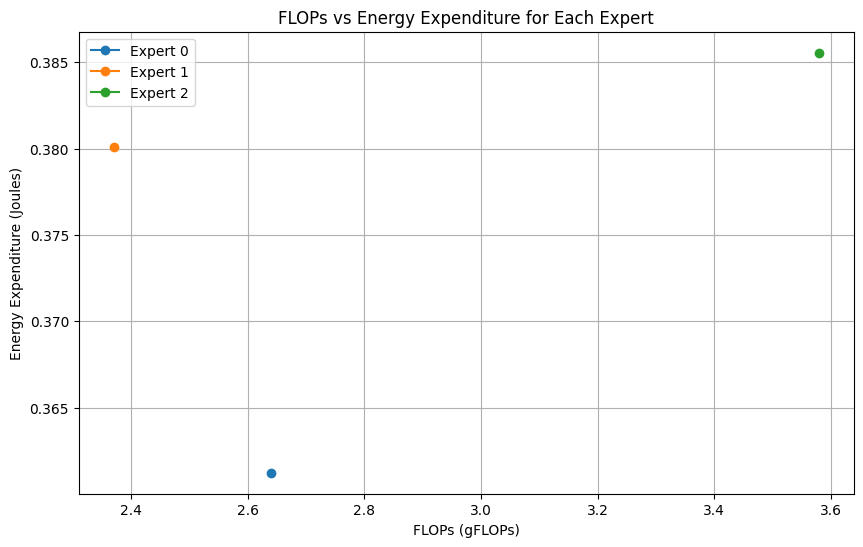

Layer 4 Energy in joules:  16.556764910221098
Layer  4
  Expert 0: 0.3369 J
  Expert 0: 3.0943 gFlops
  Expert 1: 0.3411 J
  Expert 1: 2.7861 gFlops
  Expert 2: 0.4299 J
  Expert 2: 2.7095 gFlops


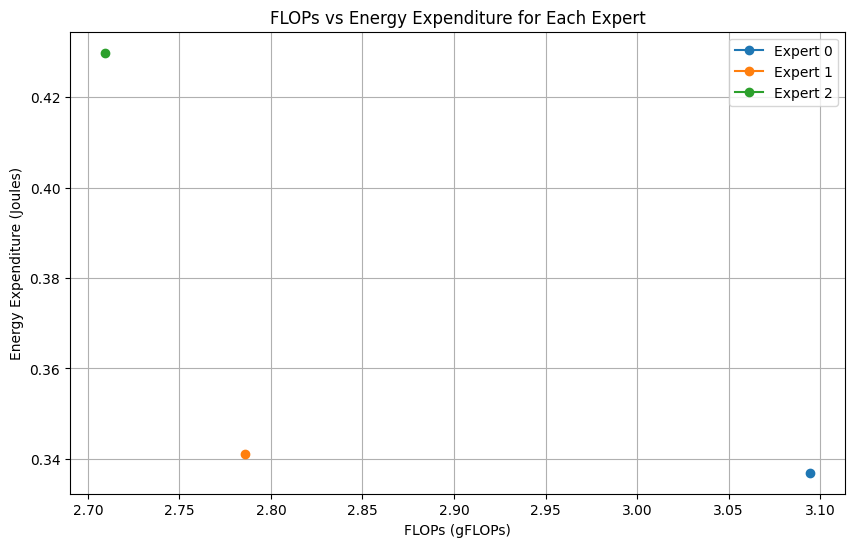

Layer 5 Energy in joules:  16.97097802877426
Layer  5
  Expert 0: 0.4441 J
  Expert 0: 2.8270 gFlops
  Expert 1: 0.4390 J
  Expert 1: 2.7578 gFlops
  Expert 2: 0.4344 J
  Expert 2: 3.0052 gFlops


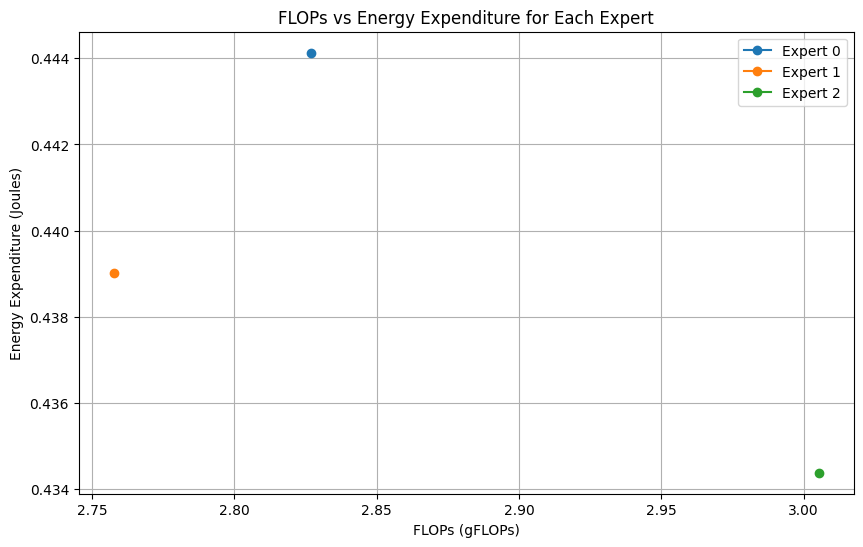

Layer 6 Energy in joules:  17.70453330755234
Layer  6
  Expert 0: 0.4620 J
  Expert 0: 2.6372 gFlops
  Expert 1: 0.4042 J
  Expert 1: 3.0608 gFlops
  Expert 2: 0.4007 J
  Expert 2: 2.8920 gFlops


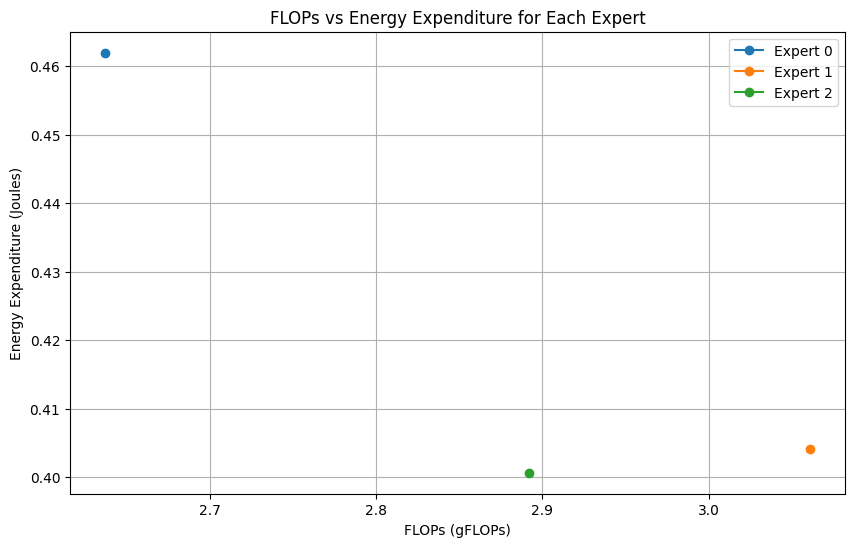

Layer 7 Energy in joules:  17.29445517539978
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.09008103706006
torch.Size([16, 256, 32000])
Input Text before noise: Originally, from Chicago, now living in Hong Kong, Jeanne studied improvisation in Chicago. She holds a B.S. in Anthropology from Loyola University of Chicago and an M.S. in Historic Preservation from the School of the Art Institute. She has performed, presented and conducted workshops in the US, Europe and Asia. Ms. Lambin’s workshops have been described as “amazing,” “powerful,” and “great fun.” Her work has been featured in the Hong Kong’s Top Notch Storytelling Festival, Liar’s League Hong Kong, Literary Death Match, the Art’s House World Voices Presents, the Moth Chicago, Story Lab and This Much is True. Ms. Lambin is a proud to be a founding member of Improv for Humanity and co-c

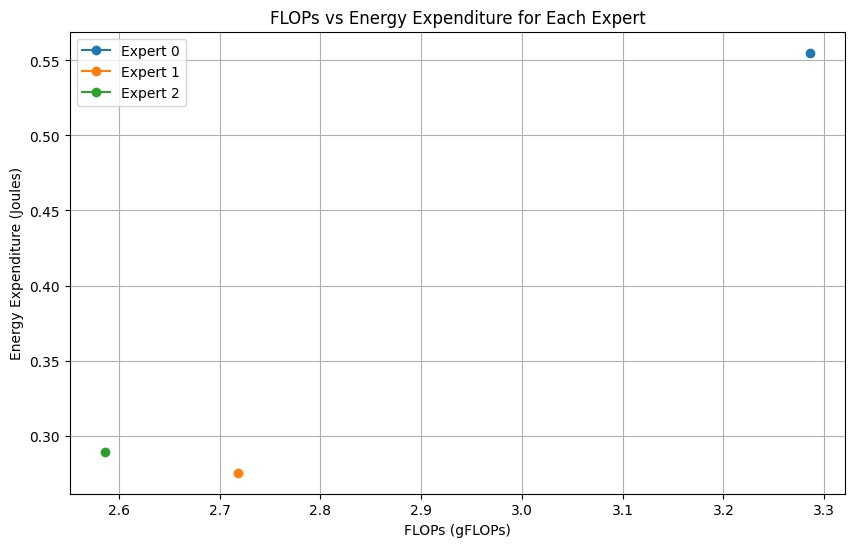

Layer 2 Energy in joules:  15.501388907432556
Layer  2
  Expert 0: 0.2350 J
  Expert 0: 2.8347 gFlops
  Expert 1: 0.2450 J
  Expert 1: 2.5935 gFlops
  Expert 2: 0.2643 J
  Expert 2: 3.1618 gFlops


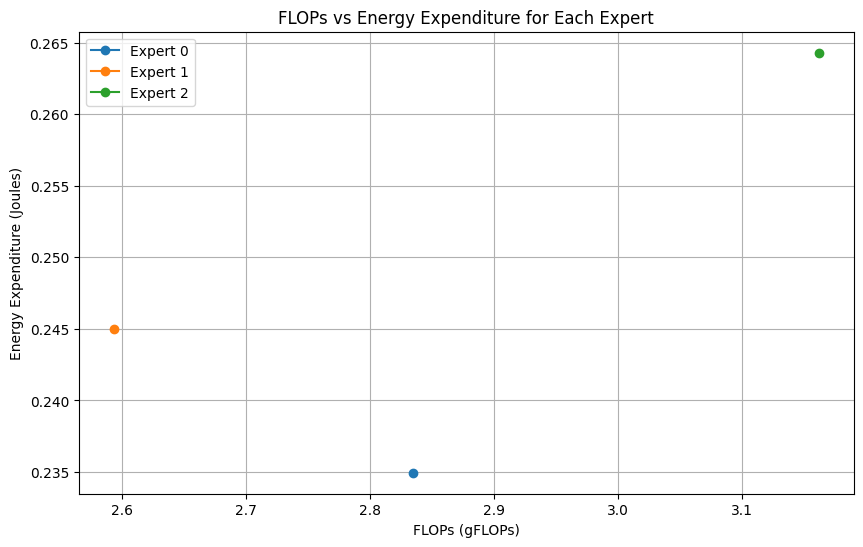

Layer 3 Energy in joules:  12.615247502326964
Layer  3
  Expert 0: 0.1960 J
  Expert 0: 2.6131 gFlops
  Expert 1: 0.2226 J
  Expert 1: 2.4320 gFlops
  Expert 2: 0.1946 J
  Expert 2: 3.5449 gFlops


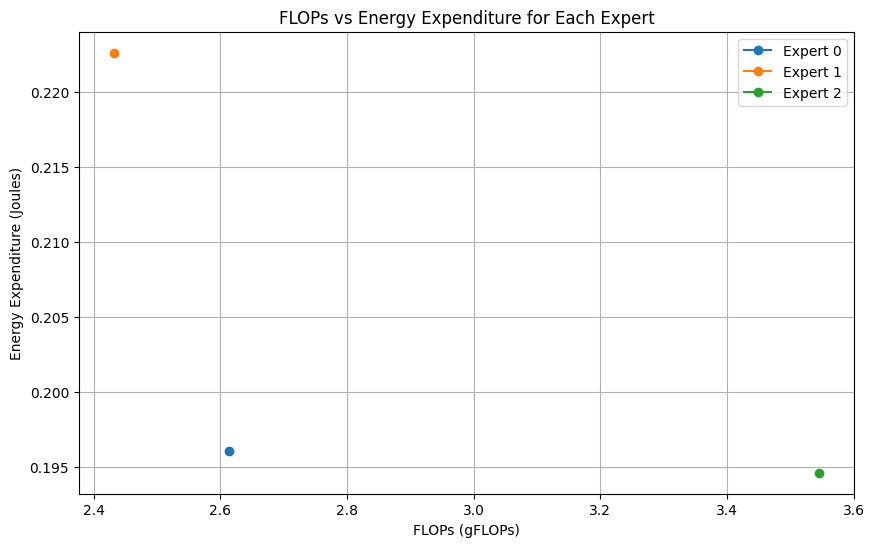

Layer 4 Energy in joules:  12.152926633358001
Layer  4
  Expert 0: 0.2091 J
  Expert 0: 2.9752 gFlops
  Expert 1: 0.2332 J
  Expert 1: 2.8179 gFlops
  Expert 2: 0.2082 J
  Expert 2: 2.7969 gFlops


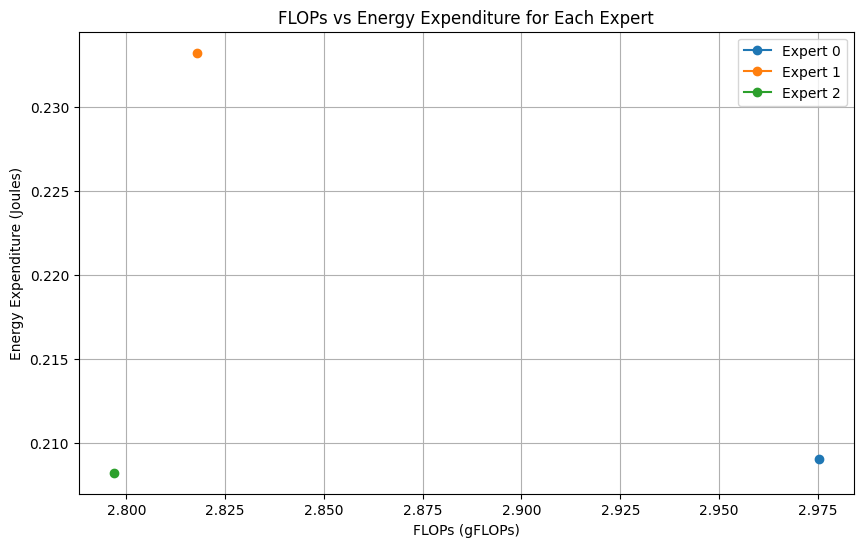

Layer 5 Energy in joules:  12.94171793460846
Layer  5
  Expert 0: 0.2352 J
  Expert 0: 2.8962 gFlops
  Expert 1: 0.2111 J
  Expert 1: 2.7640 gFlops
  Expert 2: 0.2509 J
  Expert 2: 2.9297 gFlops


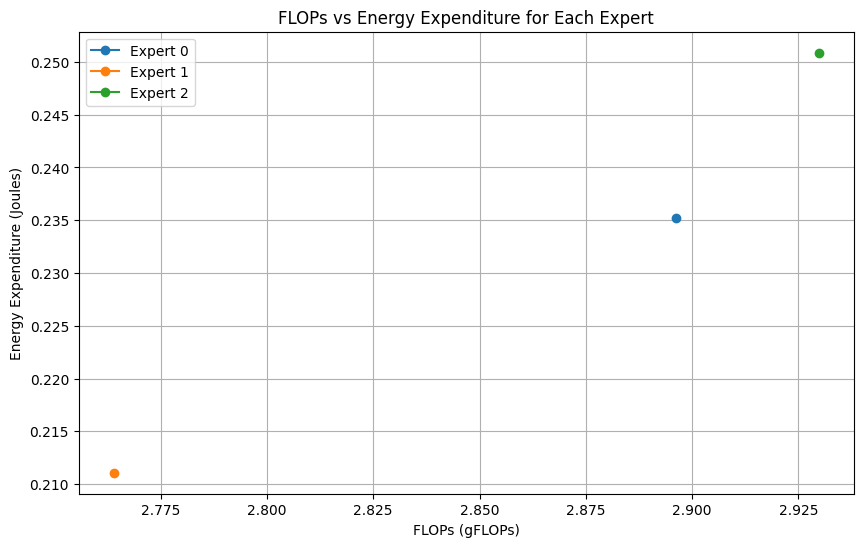

Layer 6 Energy in joules:  12.560875689983368
Layer  6
  Expert 0: 0.2491 J
  Expert 0: 2.6683 gFlops
  Expert 1: 0.2266 J
  Expert 1: 3.1178 gFlops
  Expert 2: 0.2445 J
  Expert 2: 2.8039 gFlops


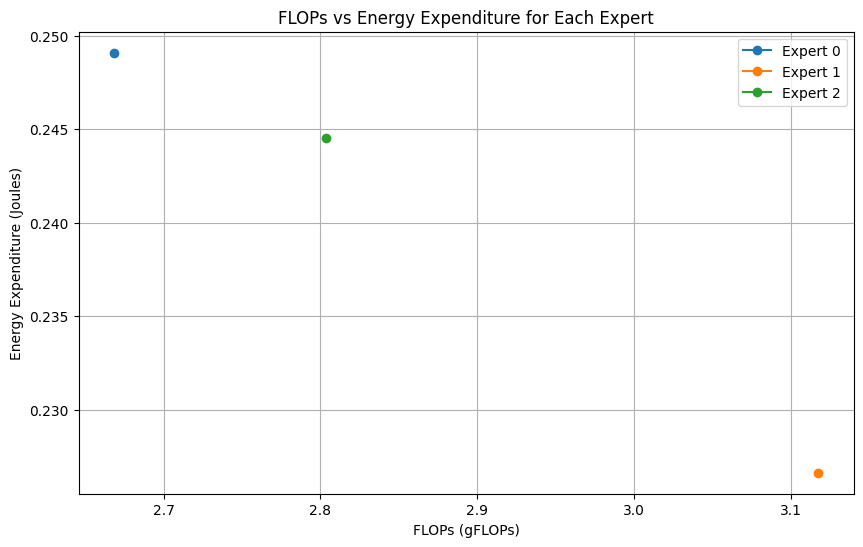

Layer 7 Energy in joules:  11.630599884986877
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Input Text before noise: Deportivo is finally responding the questions regarding the polemic case with Vecindario; the lawyers of the club aren’t only saying that the suspension of Oltra’s license is unfair, but also accused the RFEF of been attacking Depor. Deportivo is now open to negotiate with UD Vecindario in order to solve once and for all the conflict with the Canarian club. Vecindario is asking for €700,000 as part of a polemic collaboration deal that was cancelled on the past year. The conflict between Deportivo and Vecindario is now threatening Deportivo. A debt of €100,000 with Vecindario has turned into a loss of €700,000. For this conflict Oltra wasn’t on the bench for the Copa clash. One of the

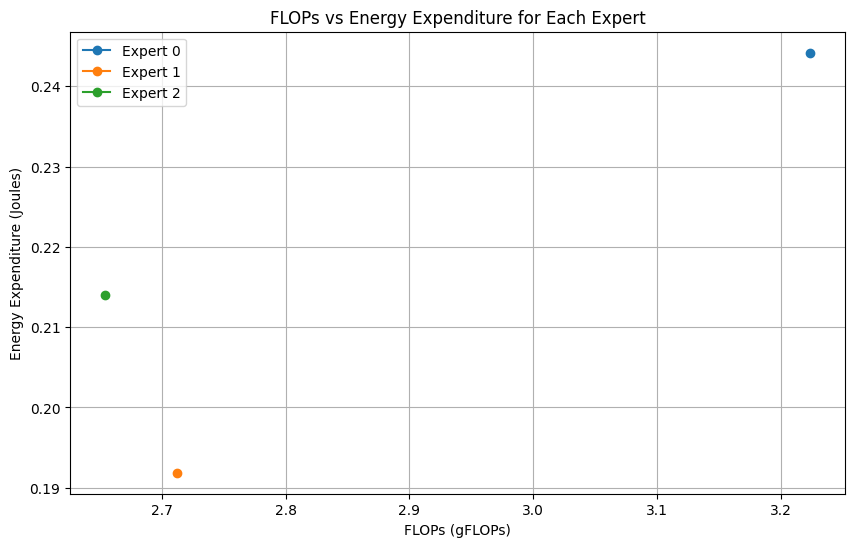

Layer 2 Energy in joules:  16.116252284049988
Layer  2
  Expert 0: 0.1802 J
  Expert 0: 2.8558 gFlops
  Expert 1: 0.3100 J
  Expert 1: 2.6131 gFlops
  Expert 2: 0.2657 J
  Expert 2: 3.1211 gFlops


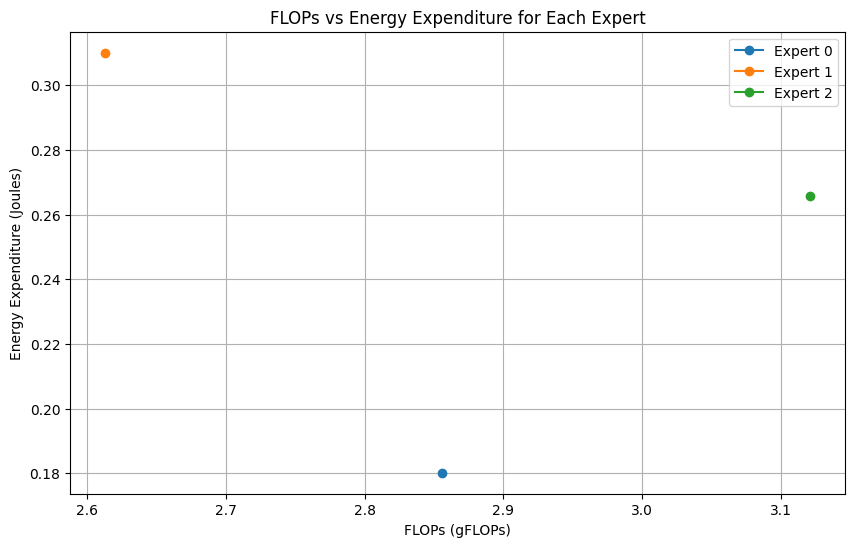

Layer 3 Energy in joules:  12.703804779052733
Layer  3
  Expert 0: 0.1374 J
  Expert 0: 2.6319 gFlops
  Expert 1: 0.1676 J
  Expert 1: 2.5176 gFlops
  Expert 2: 0.1675 J
  Expert 2: 3.4404 gFlops


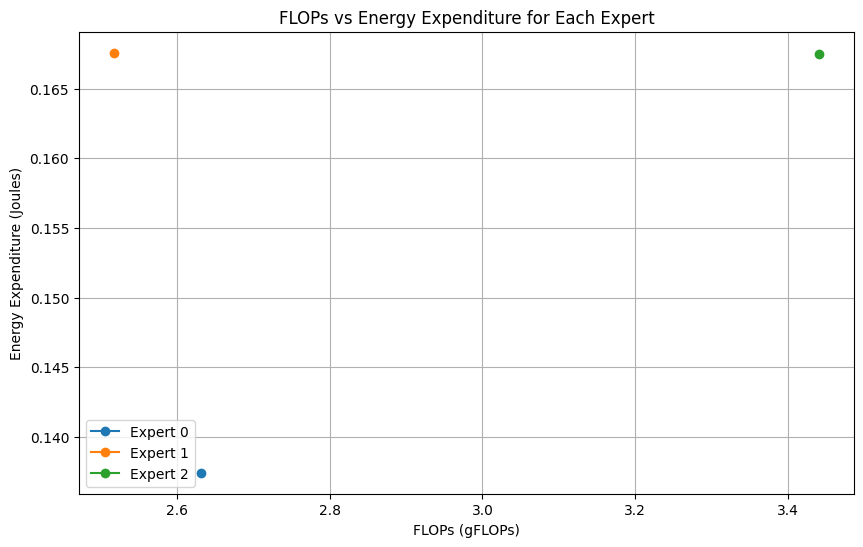

Layer 4 Energy in joules:  12.139704039096832
Layer  4
  Expert 0: 0.1414 J
  Expert 0: 2.8658 gFlops
  Expert 1: 0.1354 J
  Expert 1: 2.8962 gFlops
  Expert 2: 0.1519 J
  Expert 2: 2.8280 gFlops


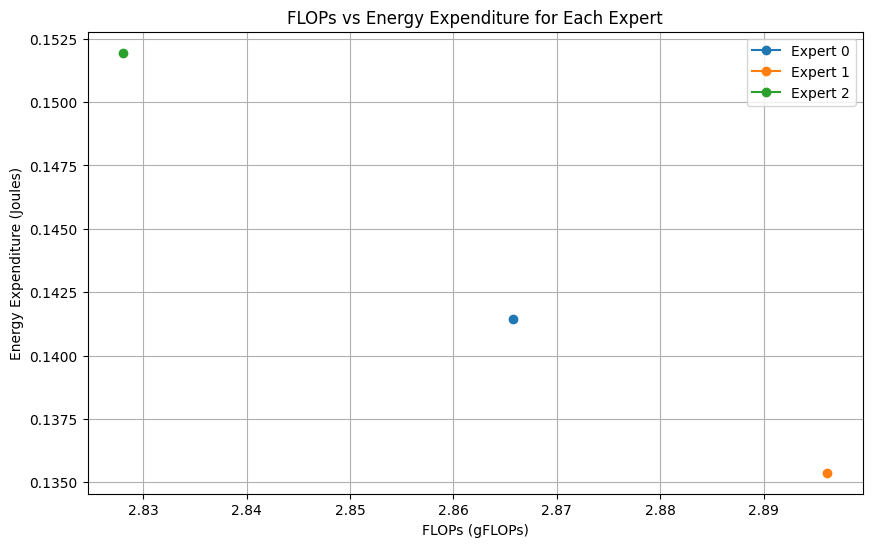

Layer 5 Energy in joules:  12.825862276554108
Layer  5
  Expert 0: 0.1346 J
  Expert 0: 2.9014 gFlops
  Expert 1: 0.1579 J
  Expert 1: 2.7751 gFlops
  Expert 2: 0.1575 J
  Expert 2: 2.9135 gFlops


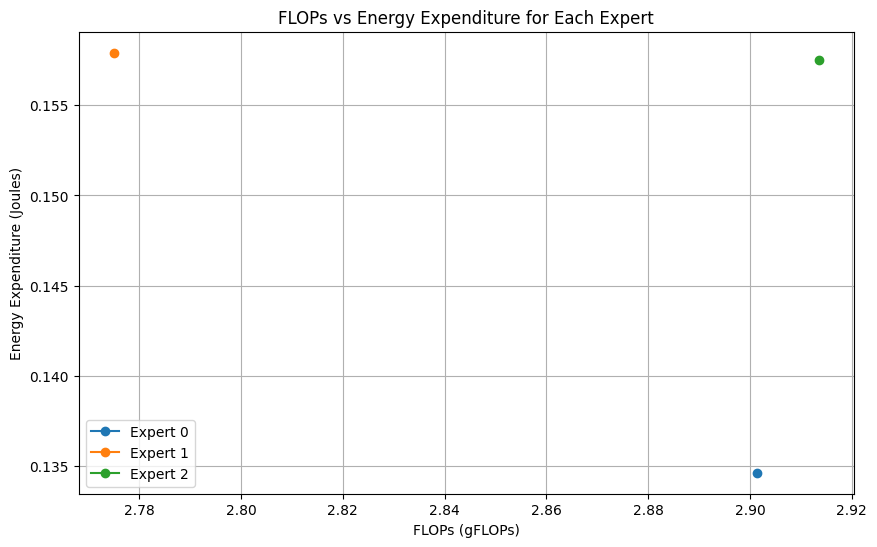

Layer 6 Energy in joules:  12.254674129486085
Layer  6
  Expert 0: 0.1352 J
  Expert 0: 2.6959 gFlops
  Expert 1: 0.1493 J
  Expert 1: 3.1300 gFlops
  Expert 2: 0.2064 J
  Expert 2: 2.7640 gFlops


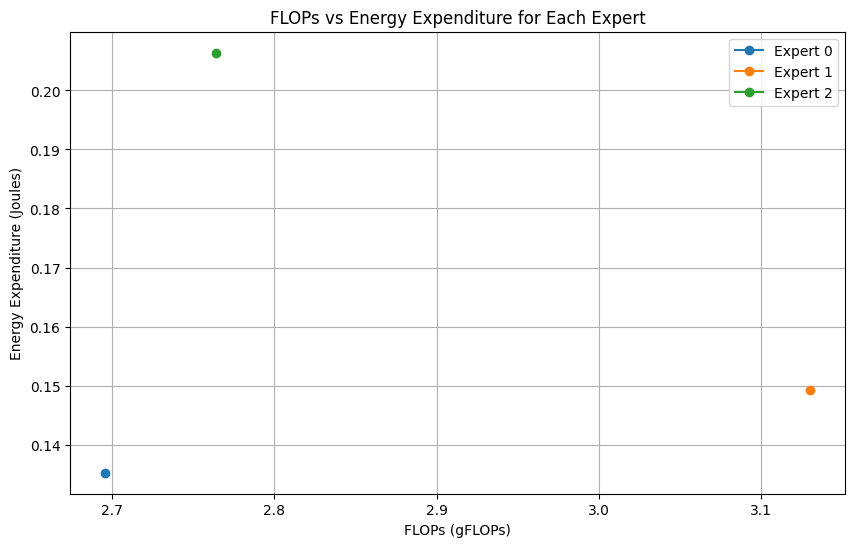

Layer 7 Energy in joules:  12.883126320838928
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.090081990734376
Layer 4 Gflops: 12.090081990734376
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090081990734376
Input Text before noise: Biomedics 1 Day Extra are daily replacement disposable contact lenses by CooperVision Hydron. Buy one box of 90 lenses. Biomedics 1 Day Extra contacts give you all the convenience of a daily disposable lens with no need for solutions, cases or cleaning and are perfect for the occasional wear. These lenses have greater comfort handling with superior ease of insertion and removal. Biomedic 1 Day Extra are also marketed under various other brand names including Clear Choice 1-day, Ascend 1-day, easyvision CLARISION SPHERE, Clearsight 1 Day and ProView Daily Disposable.
Input Text before noise: 2 New England NE 16 1 plays -1 yards 0:07 End of half. 4 Pittsburgh Pit 37 2 plays -1 yards 1:01 End of game. 2 8 opp29 1:5

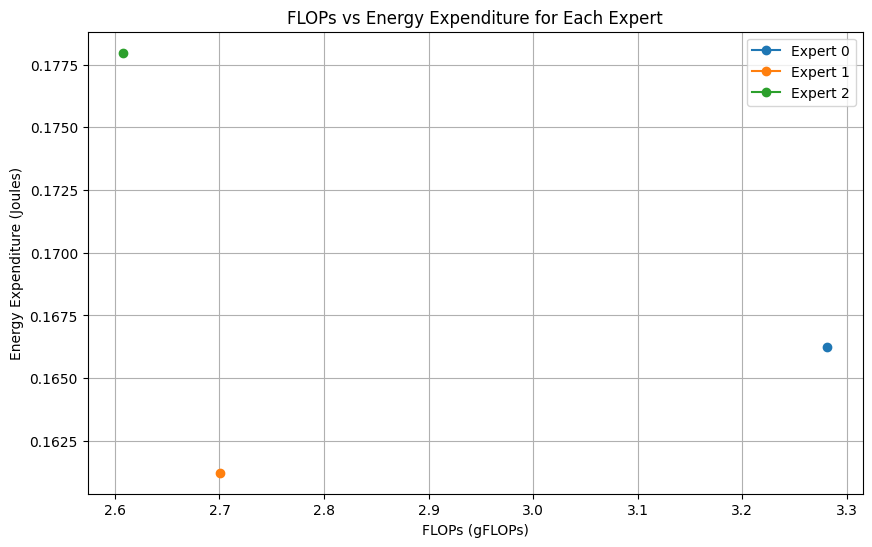

Layer 2 Energy in joules:  18.270102610588072
Layer  2
  Expert 0: 0.1534 J
  Expert 0: 2.9457 gFlops
  Expert 1: 0.1321 J
  Expert 1: 2.5870 gFlops
  Expert 2: 0.1224 J
  Expert 2: 3.0572 gFlops


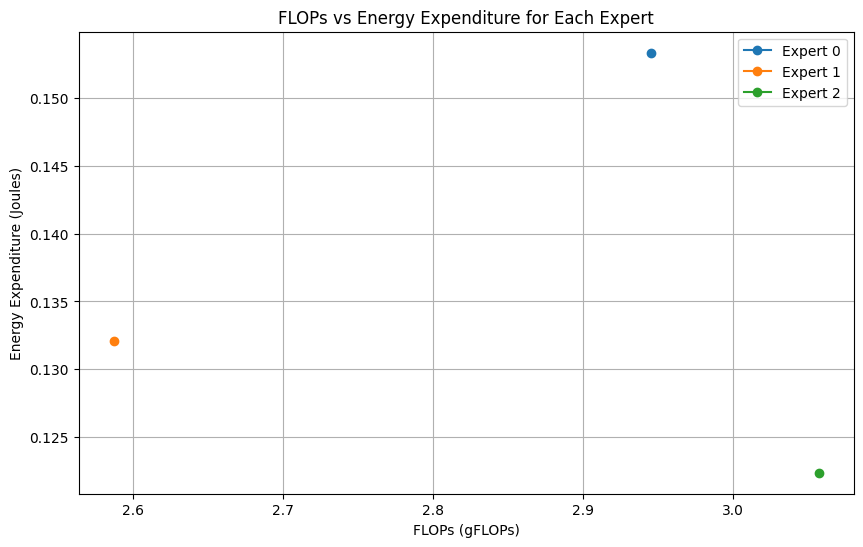

Layer 3 Energy in joules:  12.508140542507173
Layer  3
  Expert 0: 0.1272 J
  Expert 0: 2.6013 gFlops
  Expert 1: 0.1266 J
  Expert 1: 2.5703 gFlops
  Expert 2: 0.1129 J
  Expert 2: 3.4184 gFlops


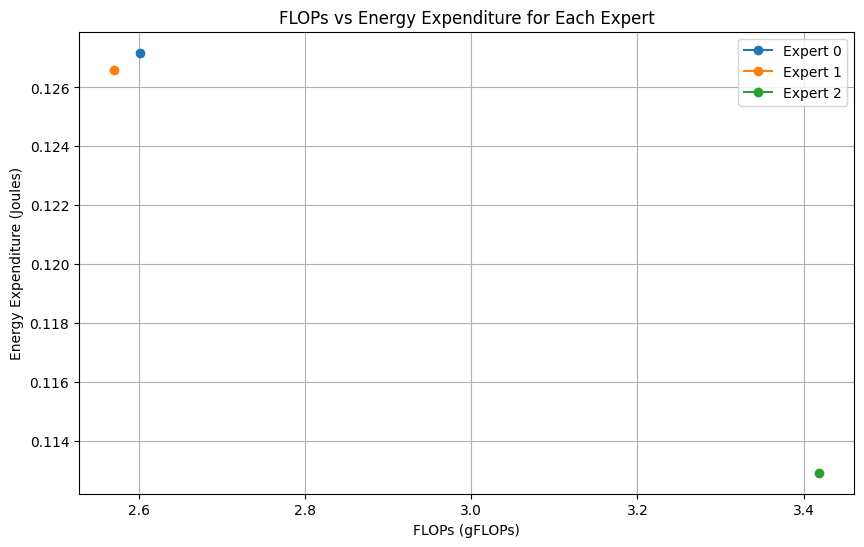

Layer 4 Energy in joules:  11.971394476890564
Layer  4
  Expert 0: 0.1563 J
  Expert 0: 2.7137 gFlops
  Expert 1: 0.1351 J
  Expert 1: 2.9855 gFlops
  Expert 2: 0.1362 J
  Expert 2: 2.8907 gFlops


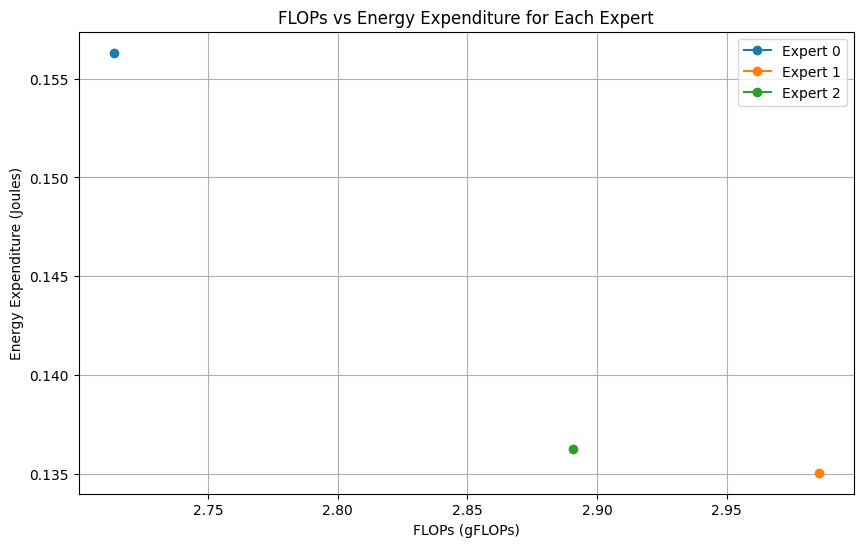

Layer 5 Energy in joules:  12.219421195983886
Layer  5
  Expert 0: 0.1268 J
  Expert 0: 2.8555 gFlops
  Expert 1: 0.1245 J
  Expert 1: 2.7917 gFlops
  Expert 2: 0.1242 J
  Expert 2: 2.9427 gFlops


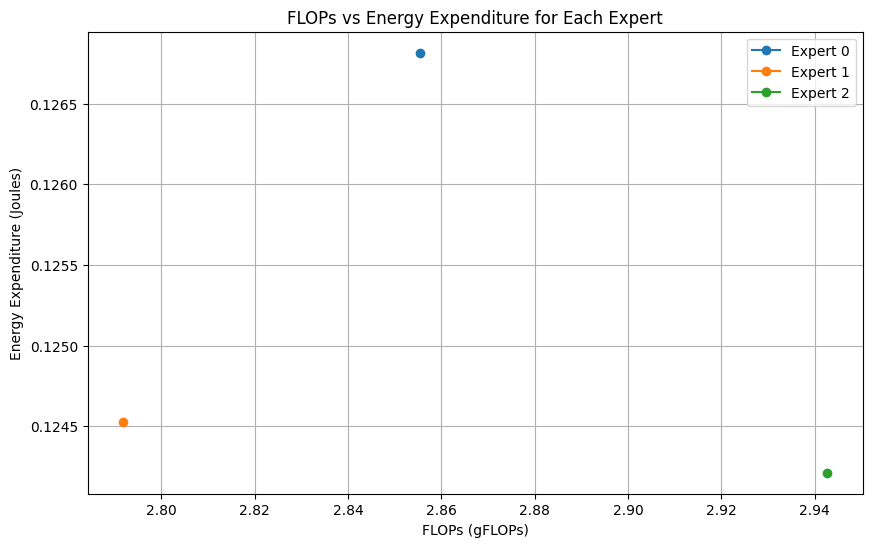

Layer 6 Energy in joules:  12.064111504554749
Layer  6
  Expert 0: 0.1138 J
  Expert 0: 2.6919 gFlops
  Expert 1: 0.1139 J
  Expert 1: 3.2183 gFlops
  Expert 2: 0.1272 J
  Expert 2: 2.6797 gFlops


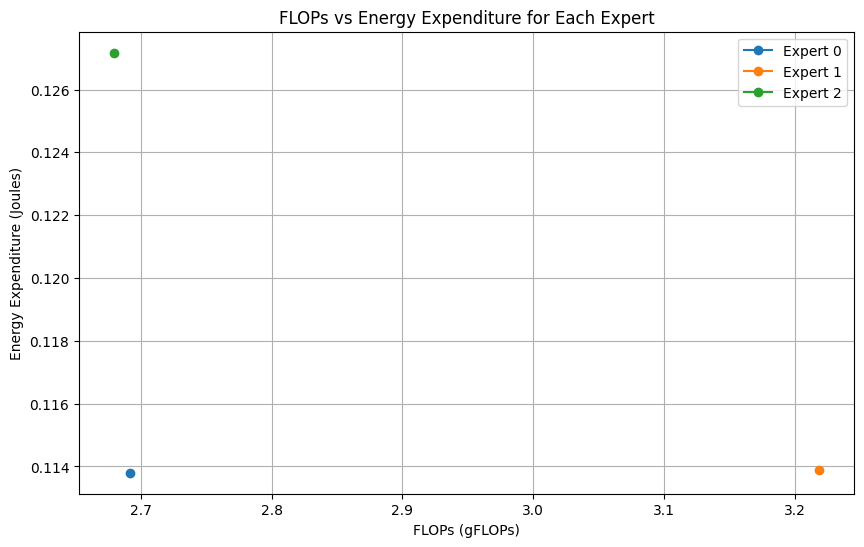

Layer 7 Energy in joules:  12.63120025396347
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.090081990734376
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Input Text before noise: Learn the fundamentals of Flash as we guide you through this comprehensive introduction to the leading interactive-design program. We will show you how to draw and animate your own graphics. This is the perfect starting point for anyone interested in creating enhanced web output. After we give you a complete tour of the Flash environment, we will take you from a blank canvas to being able to produce your own graphics and animations. You will see how it easy it is to import your own audio and video, add simple interactivity, and then publish your projects in a variety of formats. This 2-day Introduction course helps you learn about the tools and features available in Adobe Flash CC. W

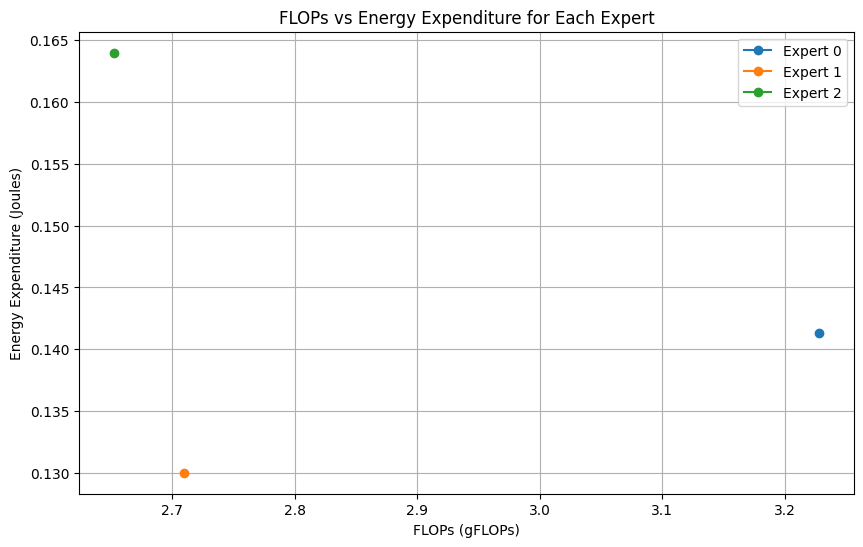

Layer 2 Energy in joules:  15.75192498445511
Layer  2
  Expert 0: 0.1270 J
  Expert 0: 2.9640 gFlops
  Expert 1: 0.1327 J
  Expert 1: 2.6358 gFlops
  Expert 2: 0.1545 J
  Expert 2: 2.9902 gFlops


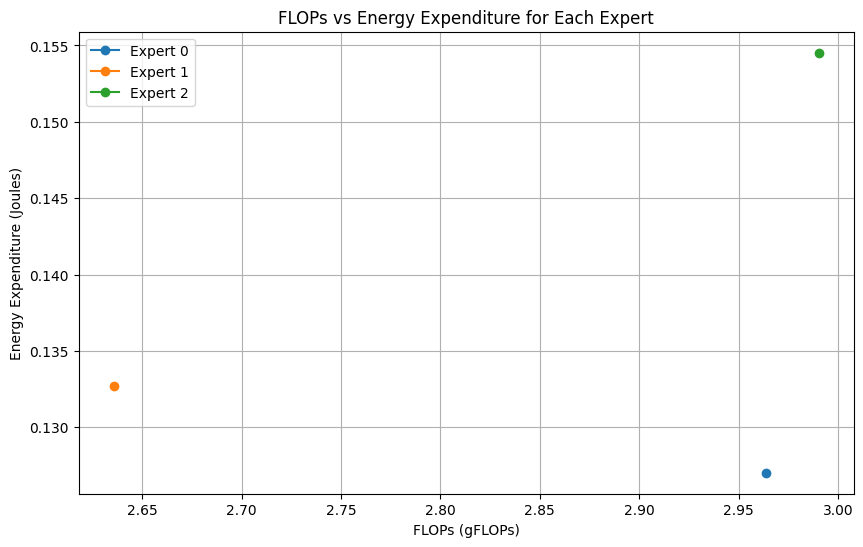

Layer 3 Energy in joules:  12.623205780982971
Layer  3
  Expert 0: 0.0952 J
  Expert 0: 2.6186 gFlops
  Expert 1: 0.0898 J
  Expert 1: 2.6424 gFlops
  Expert 2: 0.1386 J
  Expert 2: 3.3289 gFlops


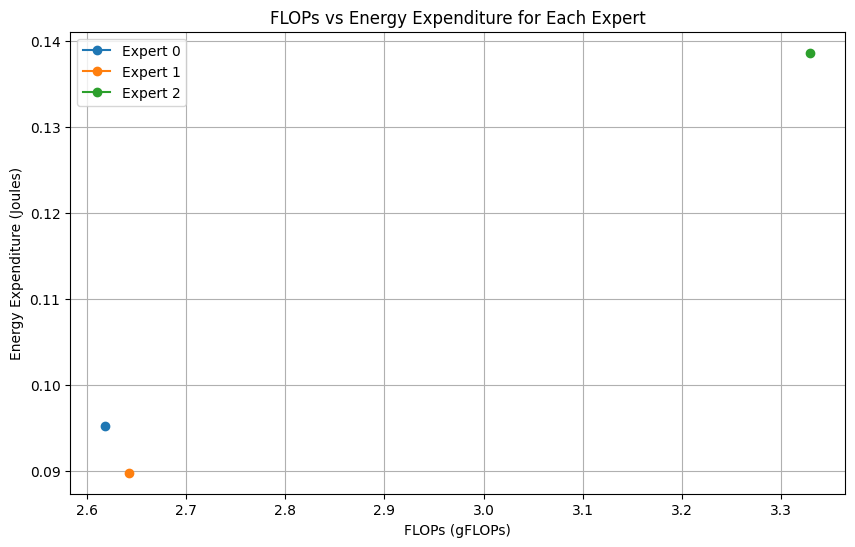

Layer 4 Energy in joules:  13.06766357421875
Layer  4
  Expert 0: 0.0944 J
  Expert 0: 2.6791 gFlops
  Expert 1: 0.1096 J
  Expert 1: 3.0716 gFlops
  Expert 2: 0.1267 J
  Expert 2: 2.8392 gFlops


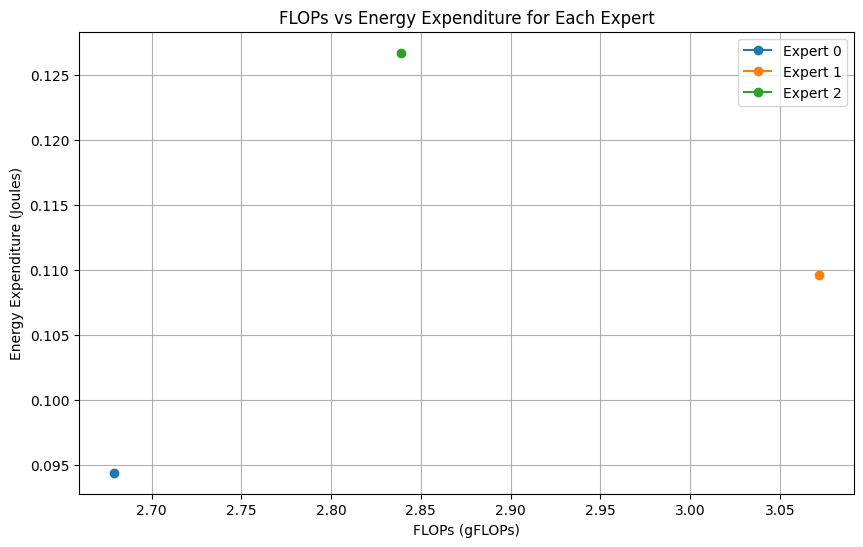

Layer 5 Energy in joules:  12.658195323944092
Layer  5
  Expert 0: 0.1025 J
  Expert 0: 2.7927 gFlops
  Expert 1: 0.1268 J
  Expert 1: 2.8528 gFlops
  Expert 2: 0.1223 J
  Expert 2: 2.9444 gFlops


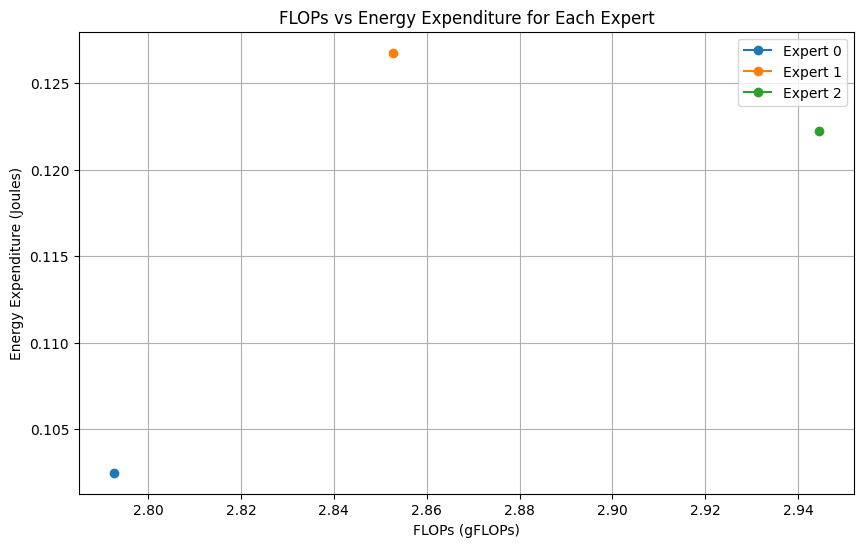

Layer 6 Energy in joules:  12.687886981964112
Layer  6
  Expert 0: 0.1071 J
  Expert 0: 2.7137 gFlops
  Expert 1: 0.1182 J
  Expert 1: 3.2010 gFlops
  Expert 2: 0.1242 J
  Expert 2: 2.6753 gFlops


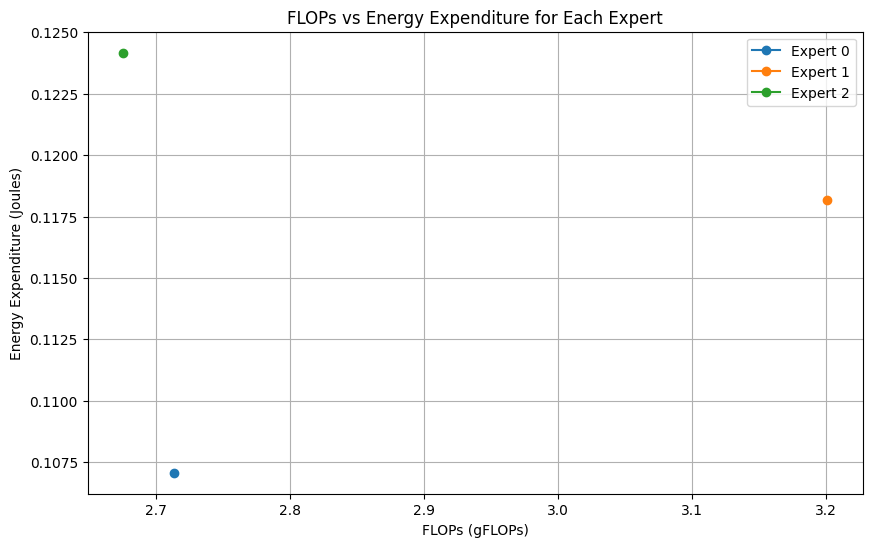

Layer 7 Energy in joules:  13.099898047447205
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Epoch 1/2, Loss: 9.747484683990479
Input Text before noise: "Whoever gets him, they'll be getting a good one," David Montgomery said. INDIANAPOLIS — Hakeem Butler has been surrounded by some of the best wide receivers on the planet this week at the NFL Scouting Combine. It’s an experience that might humble some. But for Butler, it has only enhanced his confidence. As it stands, 22-year-old Butler is not regarded as the best wide receiver in this year’s NFL Draft. He’s projected by some experts to go as late as the third round. But when wide receivers were measured Thursday, Butler gained some attention: He led all receivers in height (6-foot-5 3/8), arm length (35 1/4 inches) and wingspan (83 7/8 inches). On

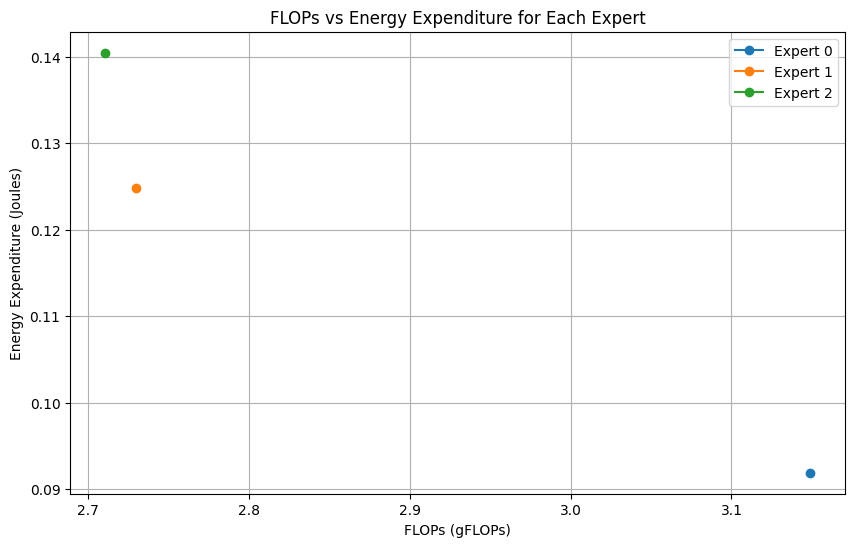

Layer 2 Energy in joules:  14.279571175575256
Layer  2
  Expert 0: 0.1118 J
  Expert 0: 2.9489 gFlops
  Expert 1: 0.1019 J
  Expert 1: 2.6838 gFlops
  Expert 2: 0.1305 J
  Expert 2: 2.9573 gFlops


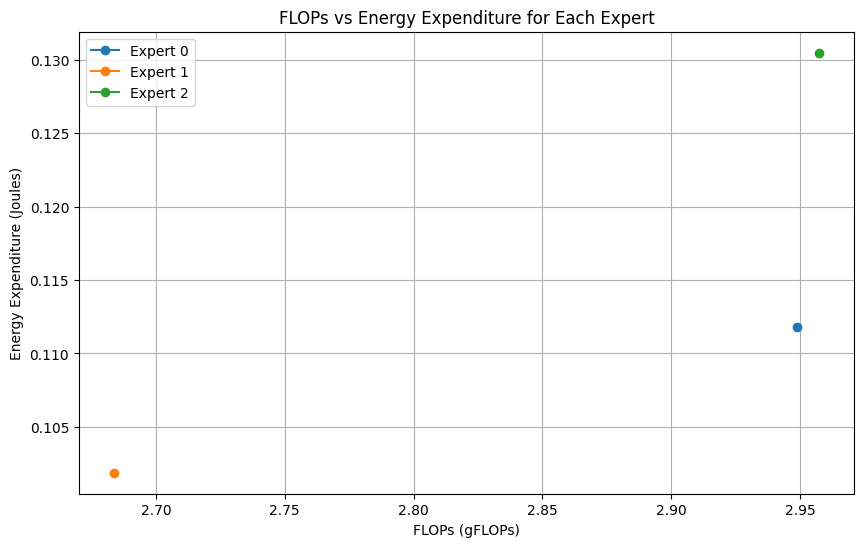

Layer 3 Energy in joules:  17.477633917331694
Layer  3
  Expert 0: 0.1004 J
  Expert 0: 2.6529 gFlops
  Expert 1: 0.1062 J
  Expert 1: 2.7182 gFlops
  Expert 2: 0.1152 J
  Expert 2: 3.2188 gFlops


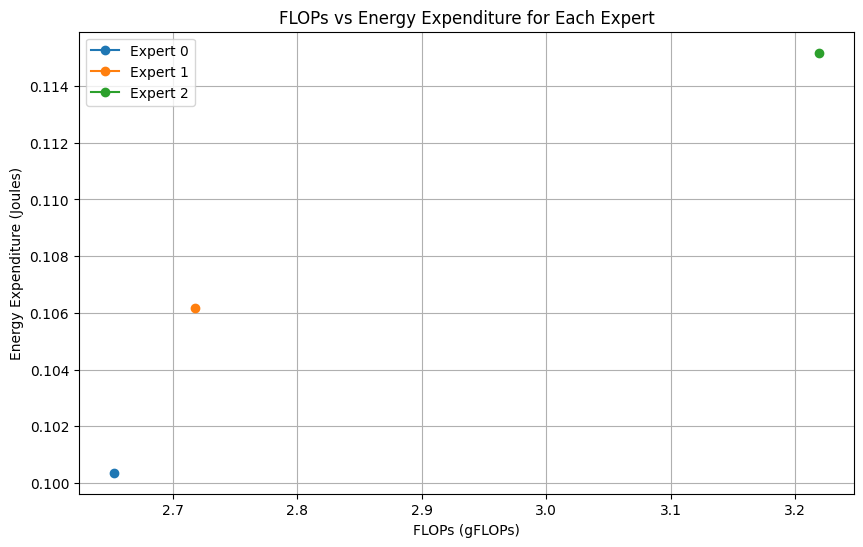

Layer 4 Energy in joules:  17.431125044822693
Layer  4
  Expert 0: 0.1203 J
  Expert 0: 2.6900 gFlops
  Expert 1: 0.1105 J
  Expert 1: 3.1457 gFlops
  Expert 2: 0.1075 J
  Expert 2: 2.7542 gFlops


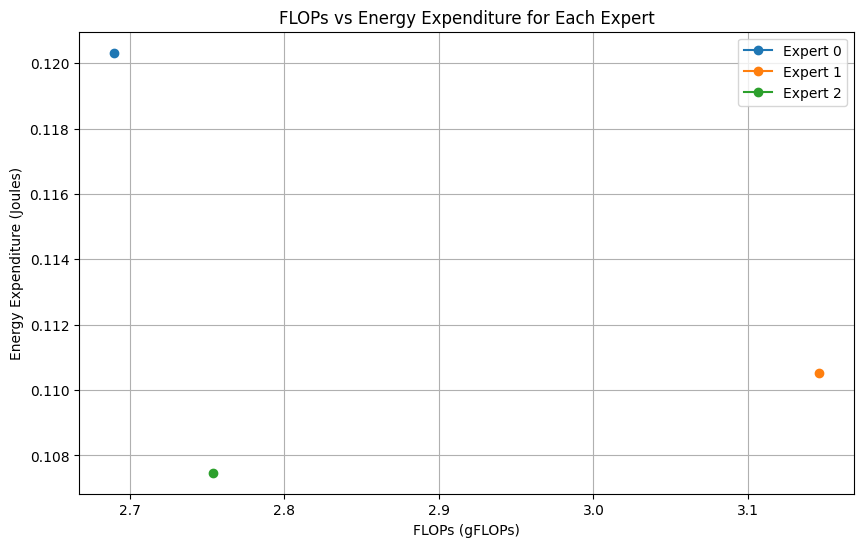

Layer 5 Energy in joules:  16.21923245191574
Layer  5
  Expert 0: 0.1068 J
  Expert 0: 2.7602 gFlops
  Expert 1: 0.0997 J
  Expert 1: 2.8941 gFlops
  Expert 2: 0.0981 J
  Expert 2: 2.9357 gFlops


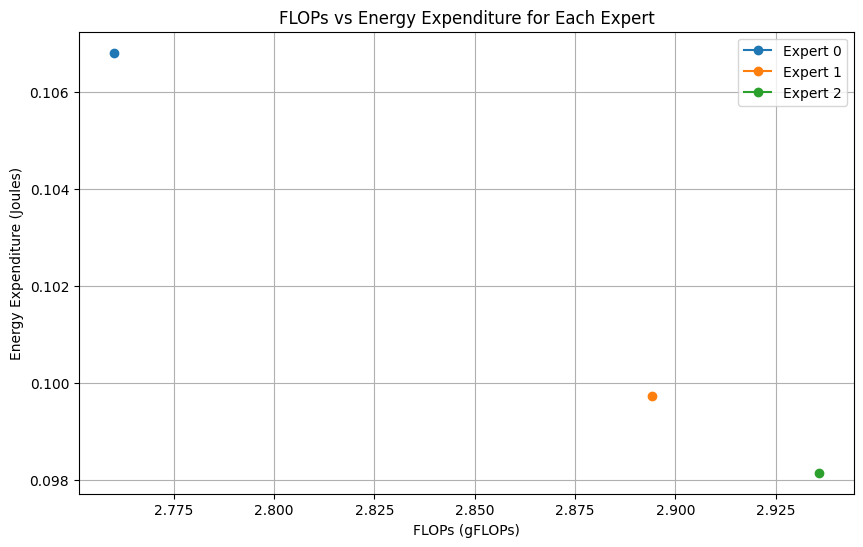

Layer 6 Energy in joules:  17.578704404830933
Layer  6
  Expert 0: 0.1163 J
  Expert 0: 2.7194 gFlops
  Expert 1: 0.1041 J
  Expert 1: 3.1628 gFlops
  Expert 2: 0.1002 J
  Expert 2: 2.7077 gFlops


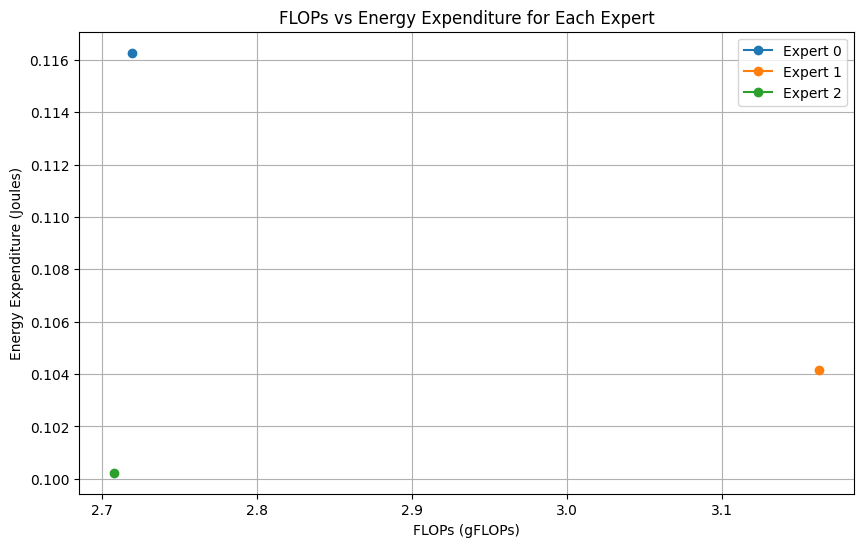

Layer 7 Energy in joules:  18.76916298866272
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Input Text before noise: Stitch can replicate data from all your sources (including Shippo) to a central warehouse. From there, it's easy to use Slemma to perform the in-depth analysis you need. Integrate Shippo and Slemma to turn your data into actionable insights.
Input Text before noise: So you have your children writing every day. Great! Now, of course, you need to become their editor. Here is where some find a challenge in the natural approach to language arts. What if I don’t feel competent to edit my child’s writing? We’ll address the underlying problem with that argument further down, but for now — here are 10 ways to become a better editor of your child’s writing. 1. Read A Strong Start in Language. Th

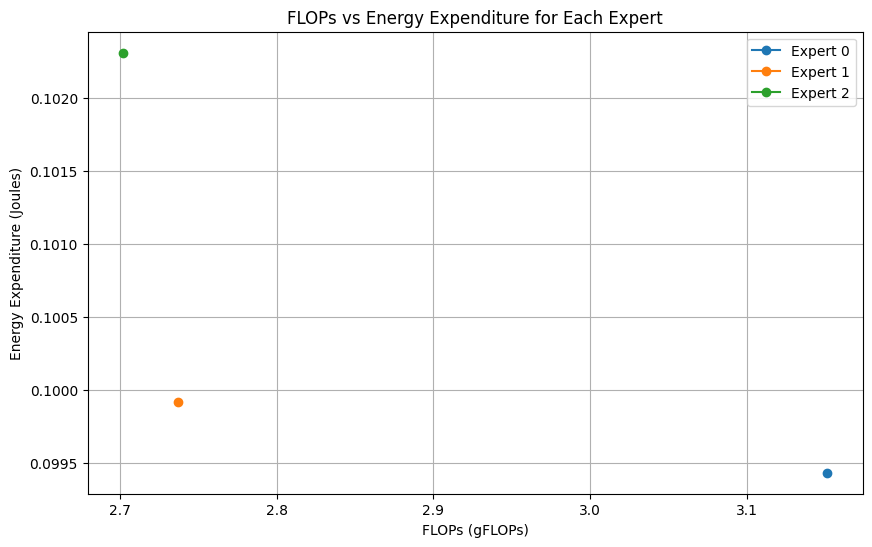

Layer 2 Energy in joules:  16.59331542491913
Layer  2
  Expert 0: 0.1145 J
  Expert 0: 2.9932 gFlops
  Expert 1: 0.1229 J
  Expert 1: 2.7103 gFlops
  Expert 2: 0.1264 J
  Expert 2: 2.8865 gFlops


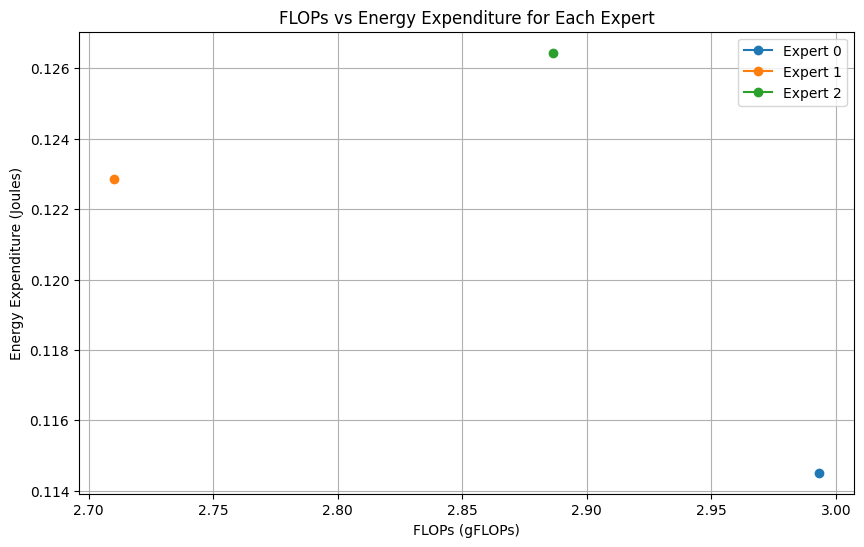

Layer 3 Energy in joules:  13.04087417602539
Layer  3
  Expert 0: 0.0683 J
  Expert 0: 2.6458 gFlops
  Expert 1: 0.0777 J
  Expert 1: 2.7612 gFlops
  Expert 2: 0.0786 J
  Expert 2: 3.1830 gFlops


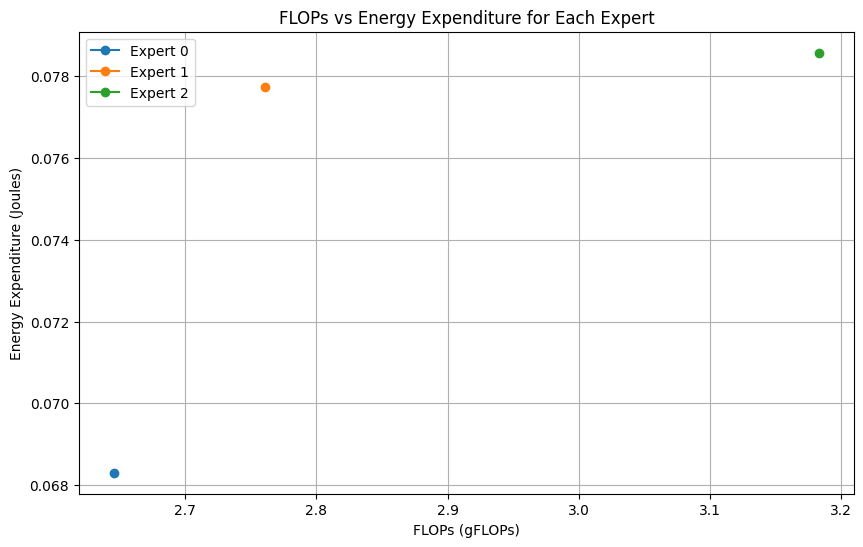

Layer 4 Energy in joules:  12.34248809814453
Layer  4
  Expert 0: 0.0810 J
  Expert 0: 2.6283 gFlops
  Expert 1: 0.0753 J
  Expert 1: 3.2170 gFlops
  Expert 2: 0.0865 J
  Expert 2: 2.7446 gFlops


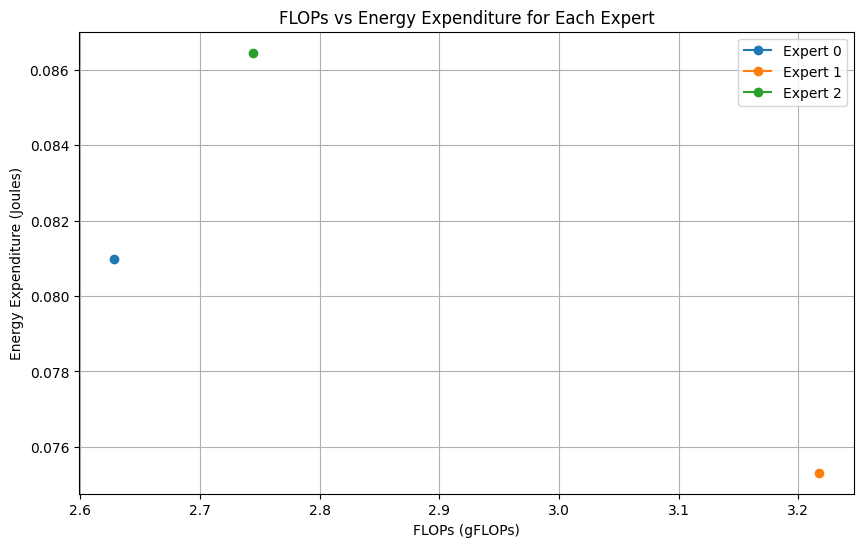

Layer 5 Energy in joules:  13.432923345565795
Layer  5
  Expert 0: 0.0760 J
  Expert 0: 2.6927 gFlops
  Expert 1: 0.0813 J
  Expert 1: 2.9578 gFlops
  Expert 2: 0.0820 J
  Expert 2: 2.9394 gFlops


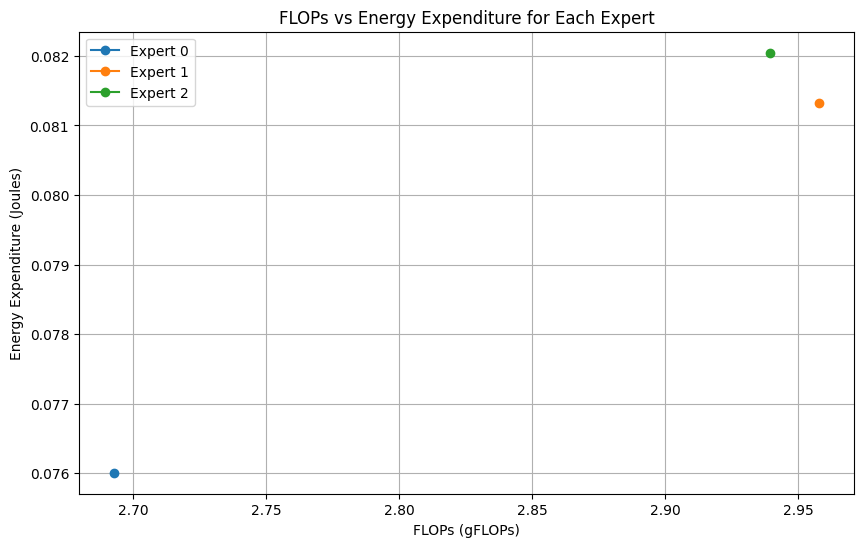

Layer 6 Energy in joules:  12.79880829334259
Layer  6
  Expert 0: 0.0764 J
  Expert 0: 2.6962 gFlops
  Expert 1: 0.0853 J
  Expert 1: 3.1761 gFlops
  Expert 2: 0.0814 J
  Expert 2: 2.7176 gFlops


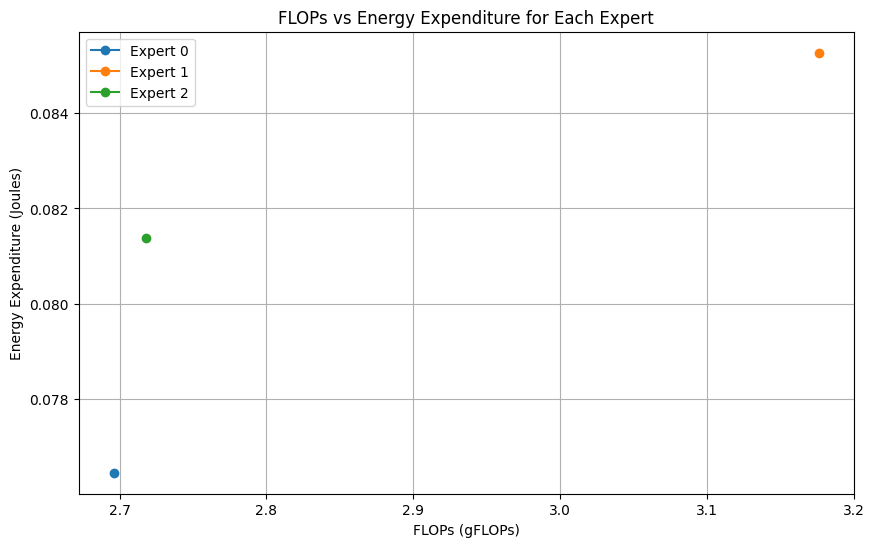

Layer 7 Energy in joules:  12.177272834777833
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Input Text before noise: I thought I was going to finish the 3rd season of the Wire tonight. But there was a commentary on episode 11, so I had to re-watch Middle Ground with the commentary. Hopefully I can finish the season next weekend.
Input Text before noise: In a small bowl, combine fennel, capers, lemon juice, parsley and olive oil and set aside. Preheat oven to 400°F. Lay trout on a greased baking sheet. Stuff each fish with slices of red onion, lemon, whole sprigs of parsley and oregano. Drizzle with olive oil and season with salt and pepper. Bake 15 to 18 minutes or until fish is firm and flakey. Serve with fennel salad.
Input Text before noise: Constant development in Unmanned Aircraft System (UAS) 

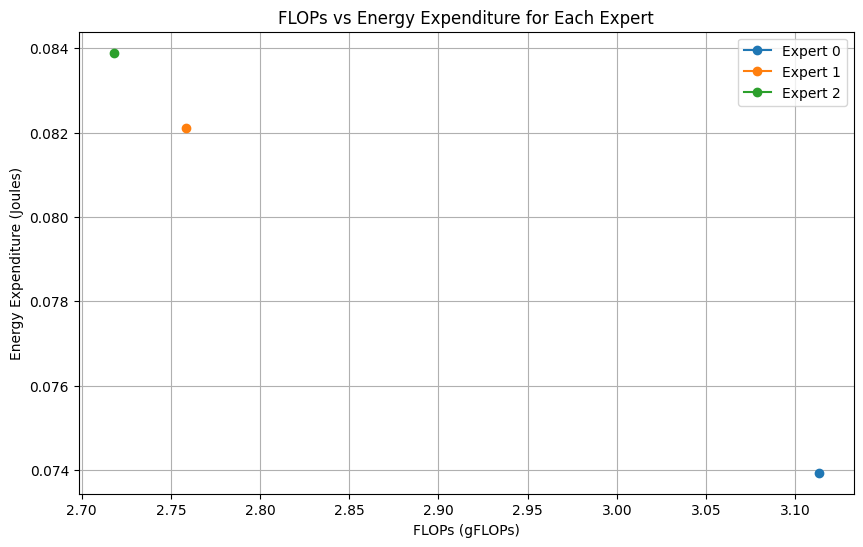

Layer 2 Energy in joules:  16.8378941488266
Layer  2
  Expert 0: 0.0811 J
  Expert 0: 2.9924 gFlops
  Expert 1: 0.0835 J
  Expert 1: 2.7536 gFlops
  Expert 2: 0.0857 J
  Expert 2: 2.8440 gFlops


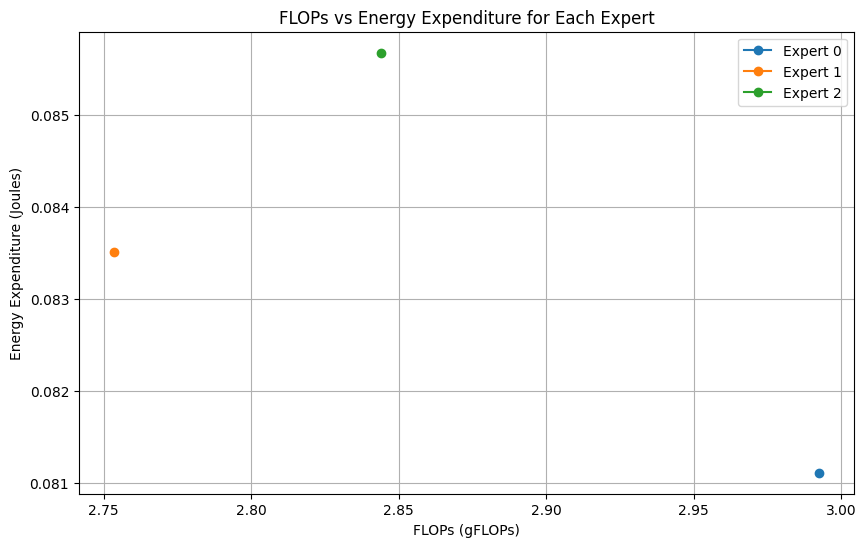

Layer 3 Energy in joules:  12.60560422897339
Layer  3
  Expert 0: 0.0650 J
  Expert 0: 2.6757 gFlops
  Expert 1: 0.0645 J
  Expert 1: 2.8125 gFlops
  Expert 2: 0.0622 J
  Expert 2: 3.1017 gFlops


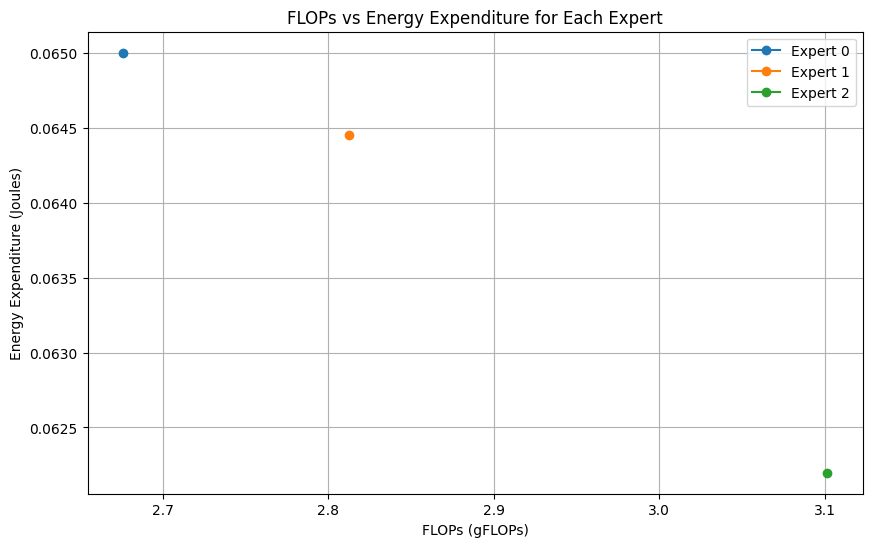

Layer 4 Energy in joules:  12.723476943969727
Layer  4
  Expert 0: 0.0649 J
  Expert 0: 2.6233 gFlops
  Expert 1: 0.0638 J
  Expert 1: 3.2869 gFlops
  Expert 2: 0.0634 J
  Expert 2: 2.6797 gFlops


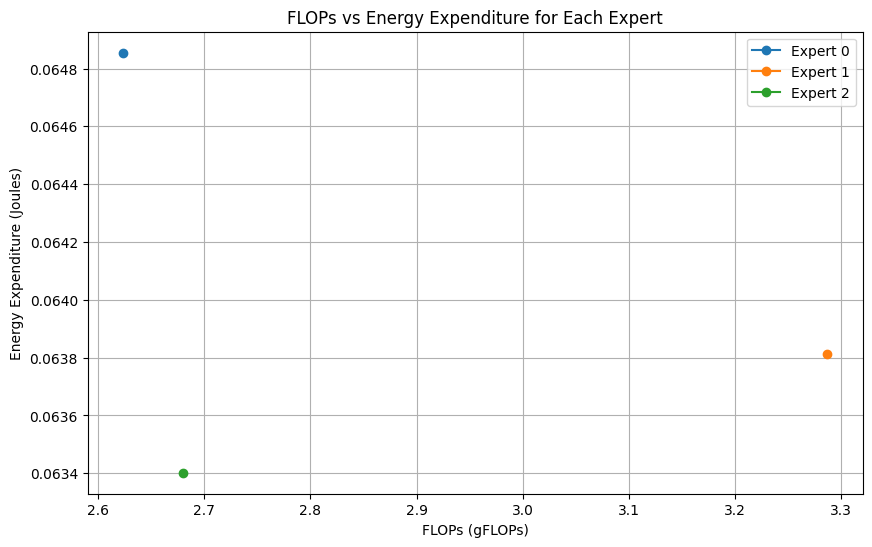

Layer 5 Energy in joules:  13.747196068763733
Layer  5
  Expert 0: 0.0717 J
  Expert 0: 2.6576 gFlops
  Expert 1: 0.0732 J
  Expert 1: 3.0115 gFlops
  Expert 2: 0.0781 J
  Expert 2: 2.9209 gFlops


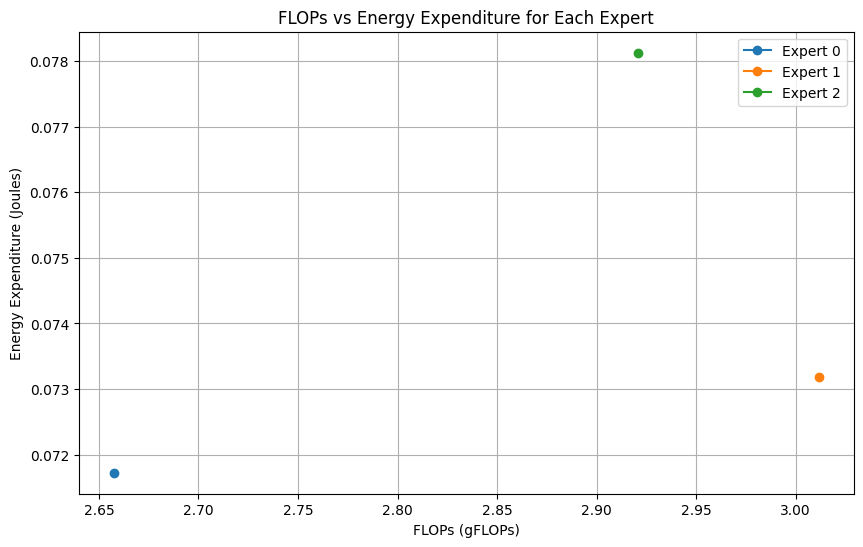

Layer 6 Energy in joules:  13.212905445098878
Layer  6
  Expert 0: 0.0633 J
  Expert 0: 2.6750 gFlops
  Expert 1: 0.0630 J
  Expert 1: 3.1506 gFlops
  Expert 2: 0.0683 J
  Expert 2: 2.7643 gFlops


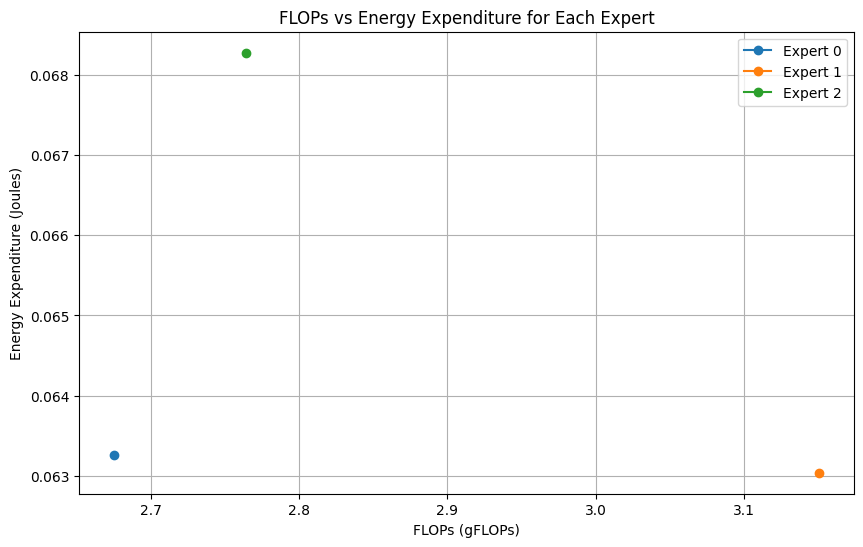

Layer 7 Energy in joules:  13.334101810455321
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Input Text before noise: Pencarian FILM Untuk "Peace Breaker 2017" yuk mampir ke channel say.. Edges East provides the l.. A corrupt cop makes one w.. Peace Breaker 2017  .. Náo Lon - Peace Break.. Please subscribe and hit.. uploaded in HD at http://.. I cannot believe I manage..
Input Text before noise: So many things happening this weekend! The highly anticipated PBS Kids in the Park festival is tomorrow, Saturday, June 21. But there are lot of other events for families to enjoy this weekend as well. Also on Saturday, check out the free Summer Solstice Celebration at the Indianapolis Museum of Art’s 100 Acre Woods. The Windsor Park Neighborhood Association will also celebrate the solstice with a festival in 

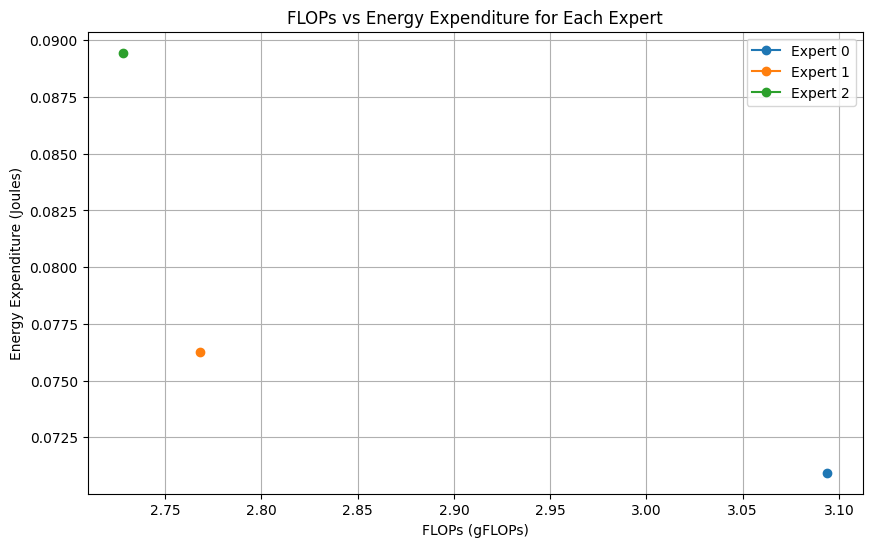

Layer 2 Energy in joules:  20.48666289806366
Layer  2
  Expert 0: 0.0809 J
  Expert 0: 3.0050 gFlops
  Expert 1: 0.0866 J
  Expert 1: 2.7810 gFlops
  Expert 2: 0.0760 J
  Expert 2: 2.8039 gFlops


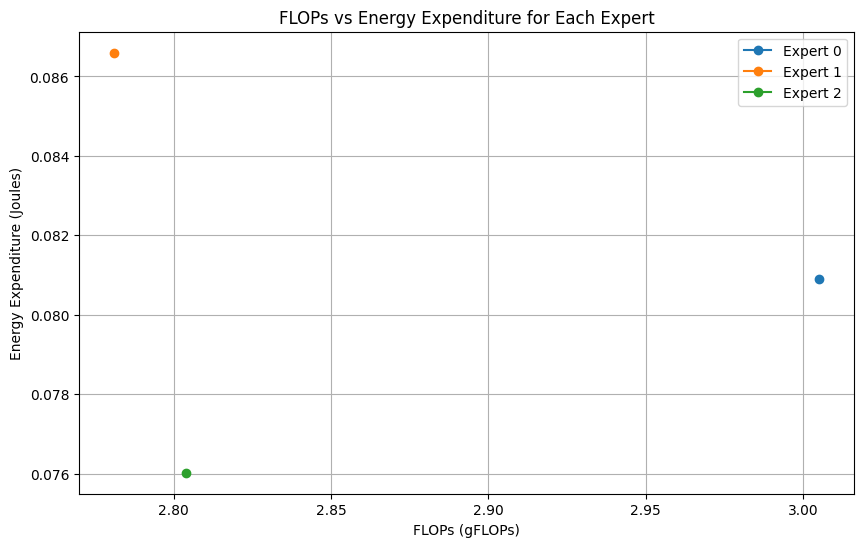

Layer 3 Energy in joules:  18.483632154464722
Layer  3
  Expert 0: 0.0793 J
  Expert 0: 2.6881 gFlops
  Expert 1: 0.0789 J
  Expert 1: 2.8498 gFlops
  Expert 2: 0.0819 J
  Expert 2: 3.0520 gFlops


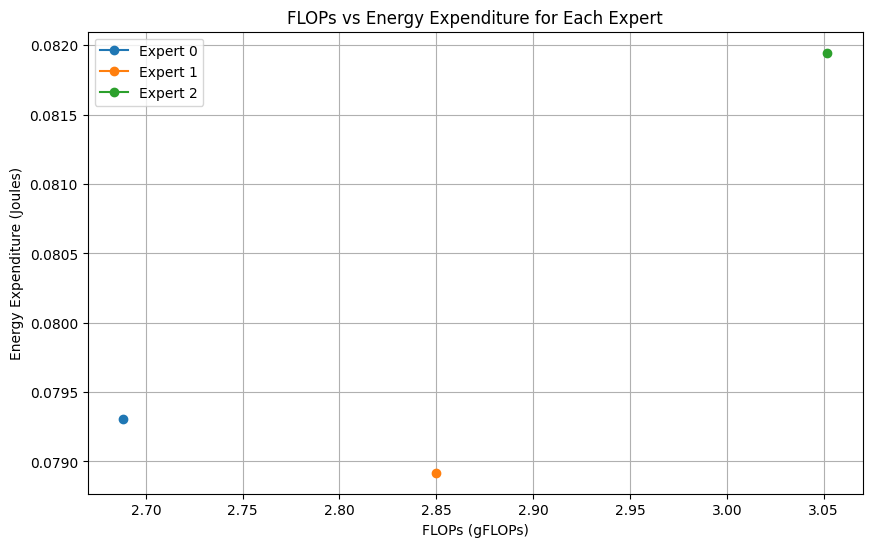

Layer 4 Energy in joules:  18.94614456176758
Layer  4
  Expert 0: 0.0596 J
  Expert 0: 2.5923 gFlops
  Expert 1: 0.0832 J
  Expert 1: 3.3458 gFlops
  Expert 2: 0.0689 J
  Expert 2: 2.6518 gFlops


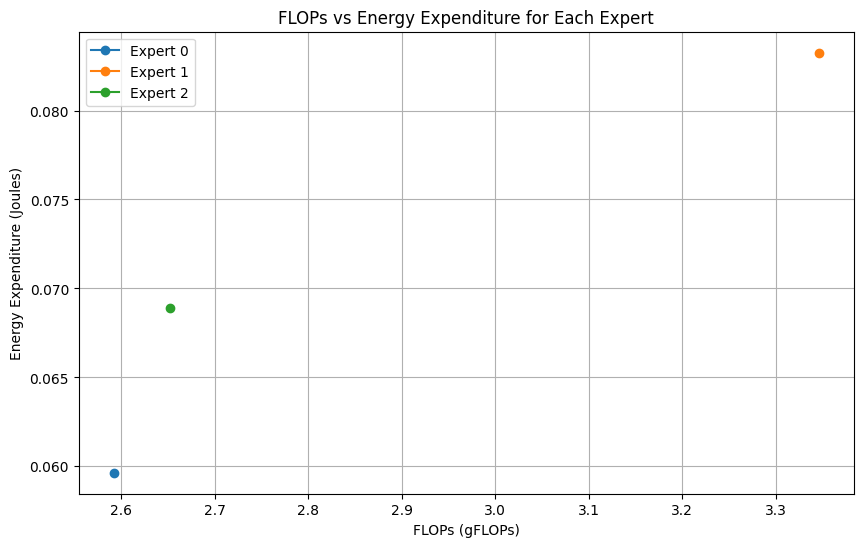

Layer 5 Energy in joules:  13.109249868392943
Layer  5
  Expert 0: 0.0599 J
  Expert 0: 2.6233 gFlops
  Expert 1: 0.0586 J
  Expert 1: 3.0595 gFlops
  Expert 2: 0.0659 J
  Expert 2: 2.9071 gFlops


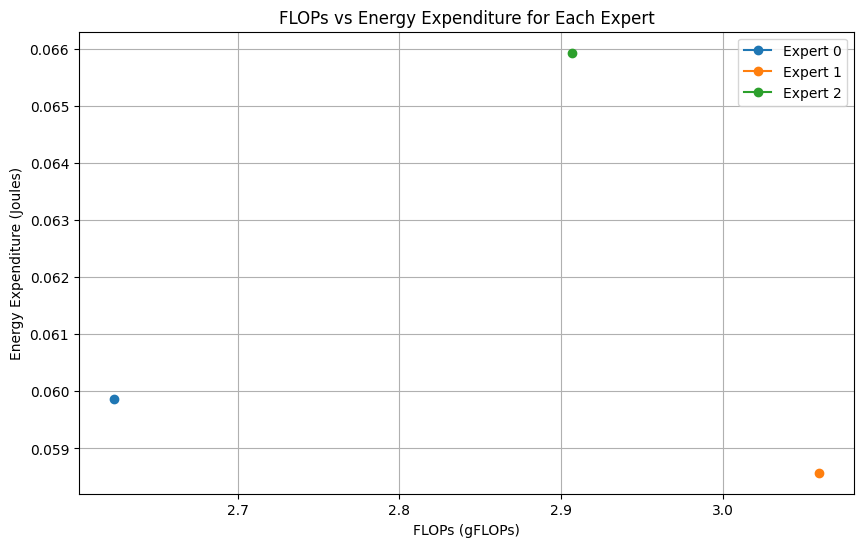

Layer 6 Energy in joules:  12.40851131916046
Layer  6
  Expert 0: 0.0699 J
  Expert 0: 2.6451 gFlops
  Expert 1: 0.0644 J
  Expert 1: 3.1499 gFlops
  Expert 2: 0.0622 J
  Expert 2: 2.7949 gFlops


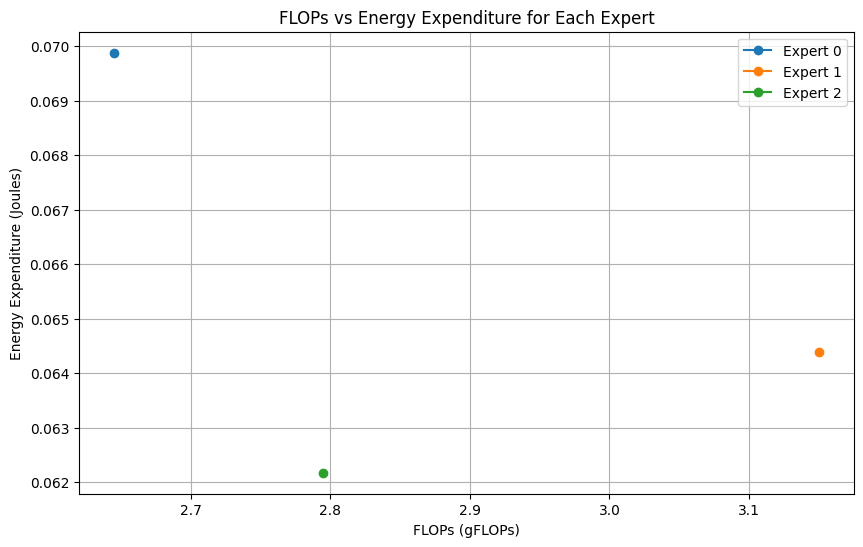

Layer 7 Energy in joules:  13.865246901512146
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.090080083385743
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.090081990734376
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Input Text before noise: Embrace world class facilities at East Bourne Resort & Spa Shimla. Facilities at East Bourne Resort & Spa Shimla comprise multi cuisine restaurant, tours and travel desk. Avail facilities of East Bourne Resort & Spa Shimla.
Input Text before noise: It is possible to erase up to 4 HDD / SSD at the same time. IDE HDD connection is also possible with dedicated adapter. HDD / SSD is exchanged from the order in which erasing is completed, and asynchronous erase function which can erase newly is installed.Five types of erase algorithms are installed. The erasing method can be selected according to the application. HDD copy function installed. It is possible to copy one HDD data to up to t

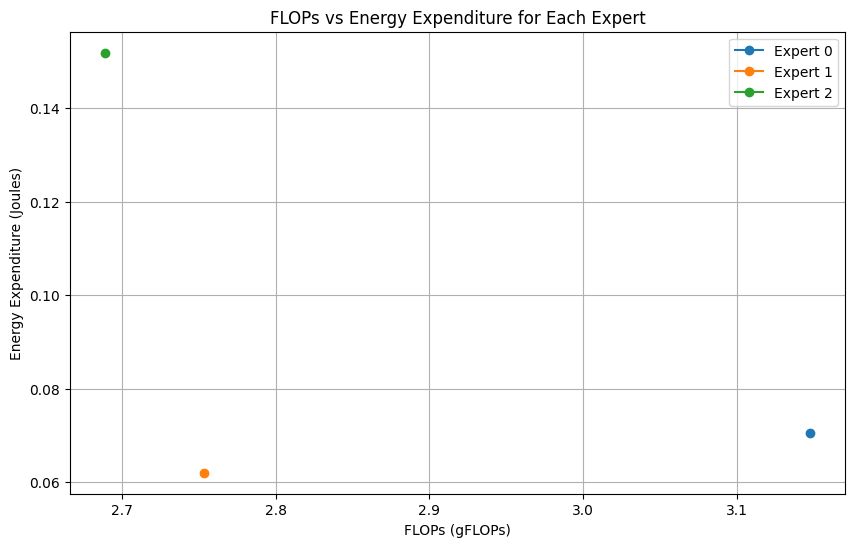

Layer 2 Energy in joules:  15.596297025680542
Layer  2
  Expert 0: 0.0785 J
  Expert 0: 3.0609 gFlops
  Expert 1: 0.0856 J
  Expert 1: 2.7970 gFlops
  Expert 2: 0.0807 J
  Expert 2: 2.7320 gFlops


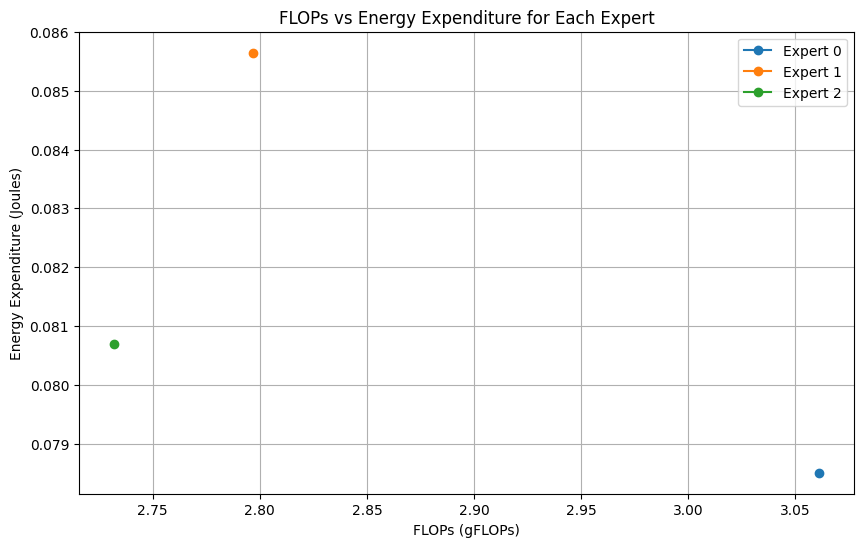

Layer 3 Energy in joules:  13.550953533649444
Layer  3
  Expert 0: 0.0569 J
  Expert 0: 2.6571 gFlops
  Expert 1: 0.0614 J
  Expert 1: 2.8477 gFlops
  Expert 2: 0.0557 J
  Expert 2: 3.0851 gFlops


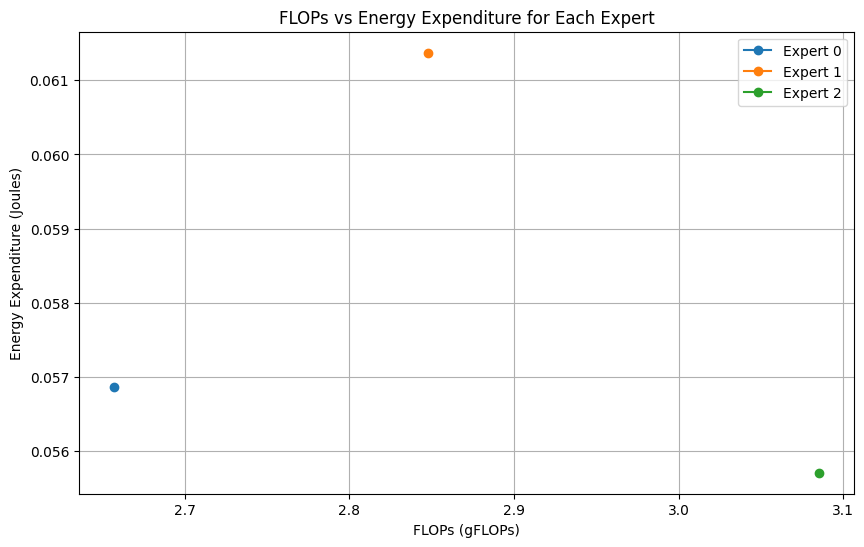

Layer 4 Energy in joules:  13.076319222450257
Layer  4
  Expert 0: 0.0615 J
  Expert 0: 2.5206 gFlops
  Expert 1: 0.0708 J
  Expert 1: 3.3675 gFlops
  Expert 2: 0.0561 J
  Expert 2: 2.7019 gFlops


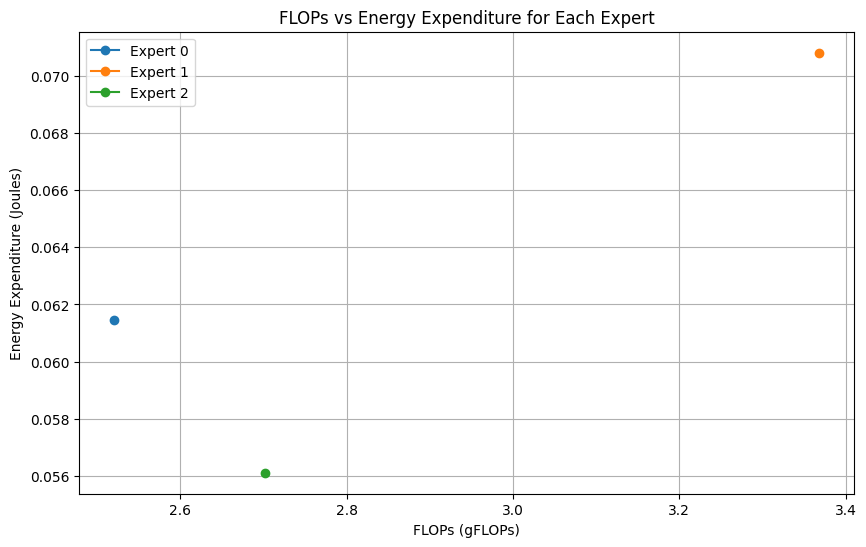

Layer 5 Energy in joules:  13.84563057899475
Layer  5
  Expert 0: 0.0551 J
  Expert 0: 2.5597 gFlops
  Expert 1: 0.0563 J
  Expert 1: 3.0946 gFlops
  Expert 2: 0.0616 J
  Expert 2: 2.9356 gFlops


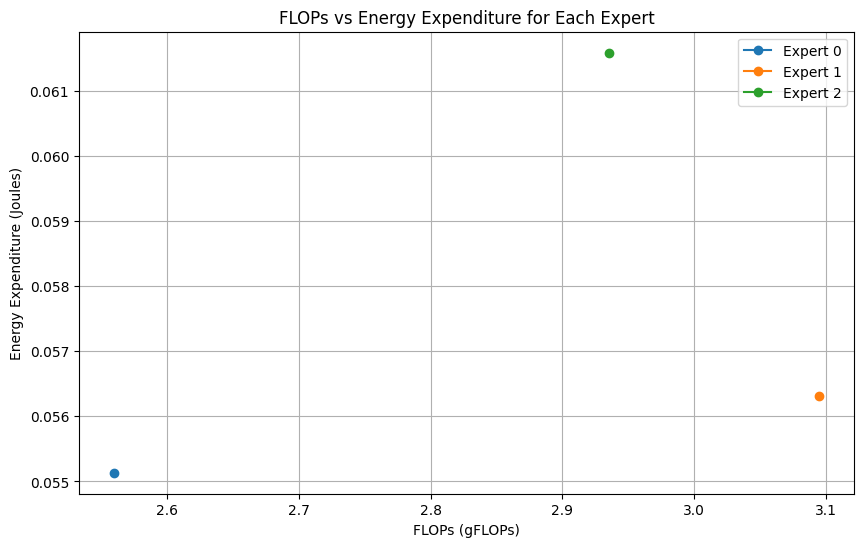

Layer 6 Energy in joules:  12.943216667175292
Layer  6
  Expert 0: 0.0612 J
  Expert 0: 2.5949 gFlops
  Expert 1: 0.0611 J
  Expert 1: 3.2046 gFlops
  Expert 2: 0.0608 J
  Expert 2: 2.7904 gFlops


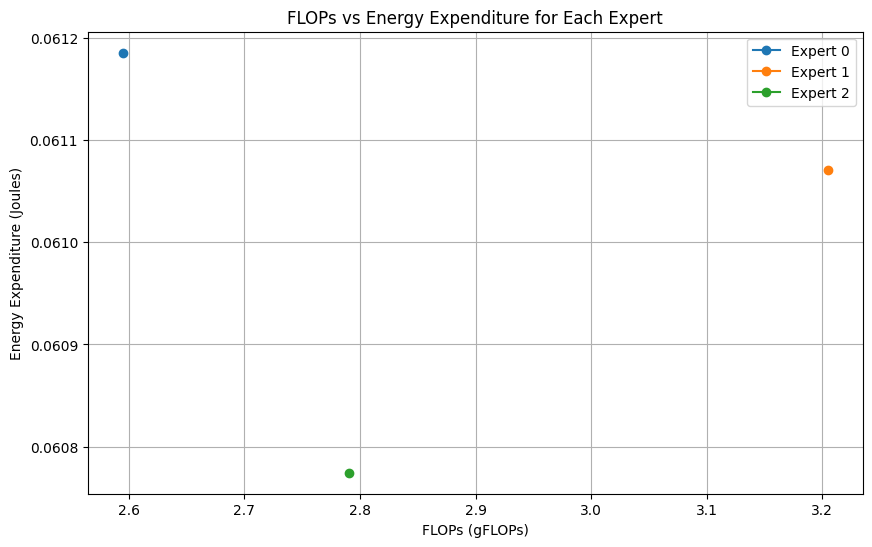

Layer 7 Energy in joules:  12.907430000305176
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.090081990734376
Layer 3 Gflops: 12.09008103706006
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Input Text before noise: Vashikaran Specialist Chandigarh is a black magic study of attraction, by which you can attract your partner, Girlfriend,Wife, Husband Anything that is living! From ages it’s going in India and everywhere in the world! It’s A Science for Welfare of Mankind. I need to recover its roots, it’s As Simple as Singing a Song and your Mate will love you for this! Kindly Don’t Use These Powers in Wrong Way on the other aspect if you done as such then these powers may hurt you! The usage of Online Vashikaran Specialist Chandigarh to win the individual love you need or treasured. It is advised that Online Vashikaran Specialist Pandit Chandigarhnot to be mishandle for imperfect or hurting other. 

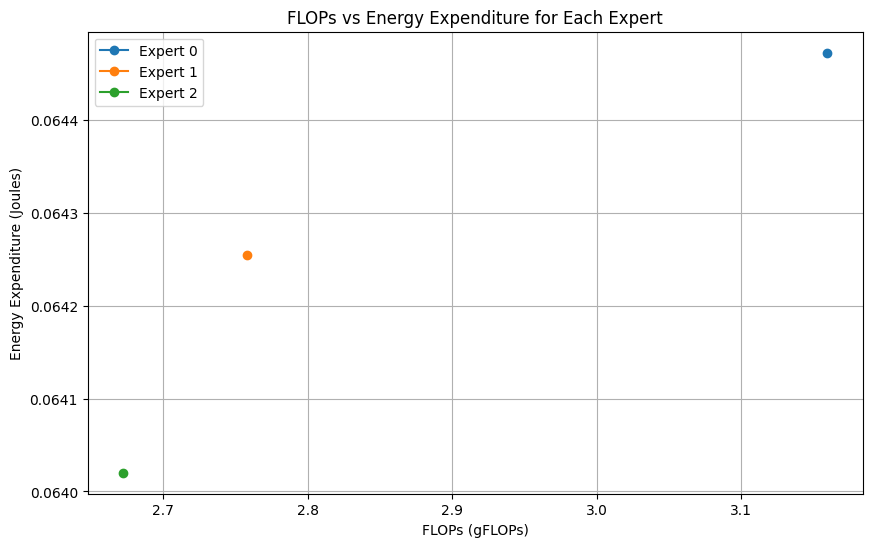

Layer 2 Energy in joules:  16.040163474082945
Layer  2
  Expert 0: 0.0670 J
  Expert 0: 3.0863 gFlops
  Expert 1: 0.0635 J
  Expert 1: 2.8175 gFlops
  Expert 2: 0.0642 J
  Expert 2: 2.6861 gFlops


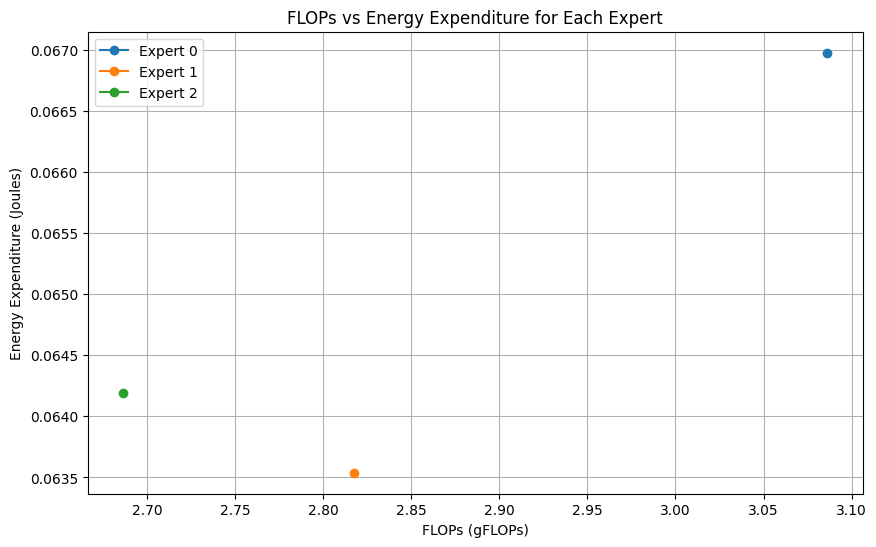

Layer 3 Energy in joules:  14.069625816345214
Layer  3
  Expert 0: 0.0679 J
  Expert 0: 2.6499 gFlops
  Expert 1: 0.0621 J
  Expert 1: 2.8624 gFlops
  Expert 2: 0.0779 J
  Expert 2: 3.0776 gFlops


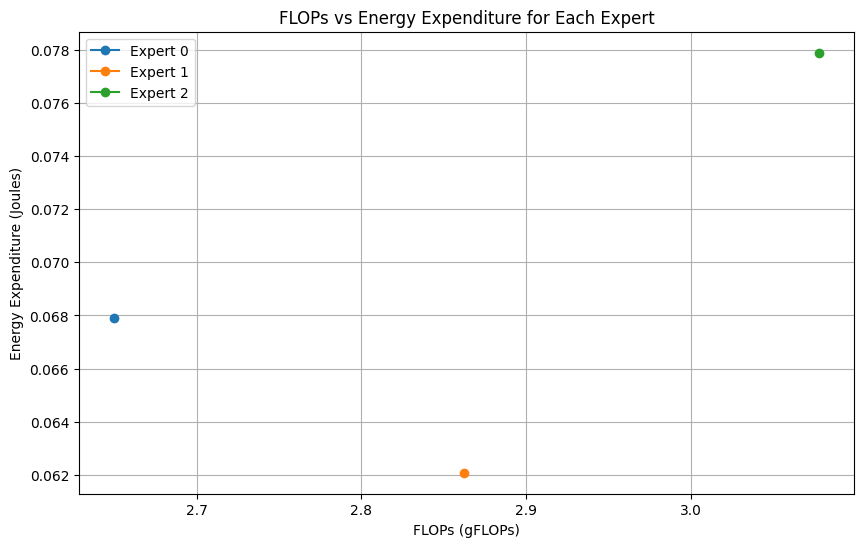

Layer 4 Energy in joules:  18.90009605407715
Layer  4
  Expert 0: 0.0620 J
  Expert 0: 2.4802 gFlops
  Expert 1: 0.0598 J
  Expert 1: 3.4004 gFlops
  Expert 2: 0.0706 J
  Expert 2: 2.7093 gFlops


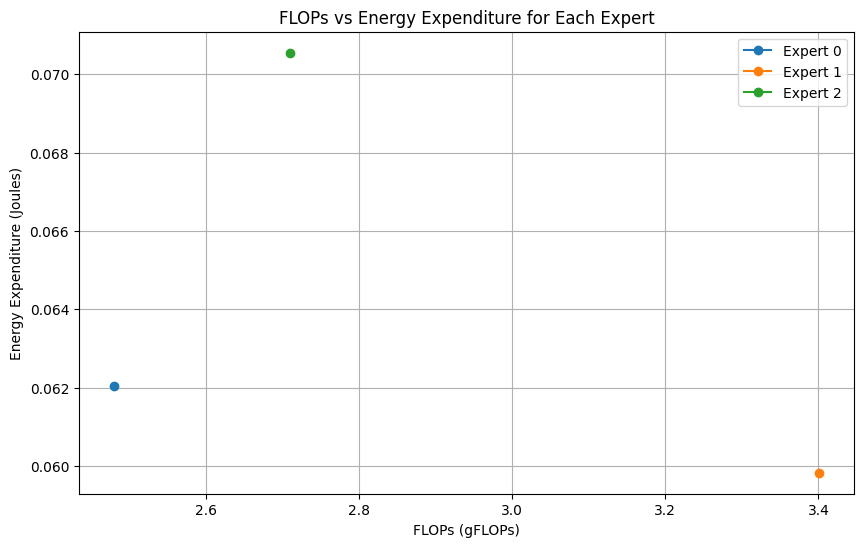

Layer 5 Energy in joules:  17.15436279773712
Layer  5
  Expert 0: 0.0677 J
  Expert 0: 2.5269 gFlops
  Expert 1: 0.0693 J
  Expert 1: 3.1202 gFlops
  Expert 2: 0.0624 J
  Expert 2: 2.9428 gFlops


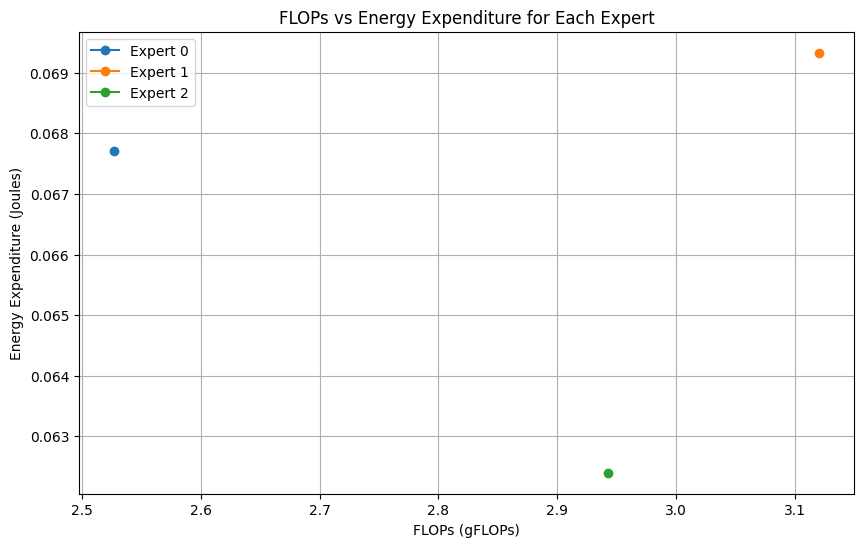

Layer 6 Energy in joules:  19.0602486038208
Layer  6
  Expert 0: 0.0805 J
  Expert 0: 2.5613 gFlops
  Expert 1: 0.0656 J
  Expert 1: 3.2268 gFlops
  Expert 2: 0.0693 J
  Expert 2: 2.8018 gFlops


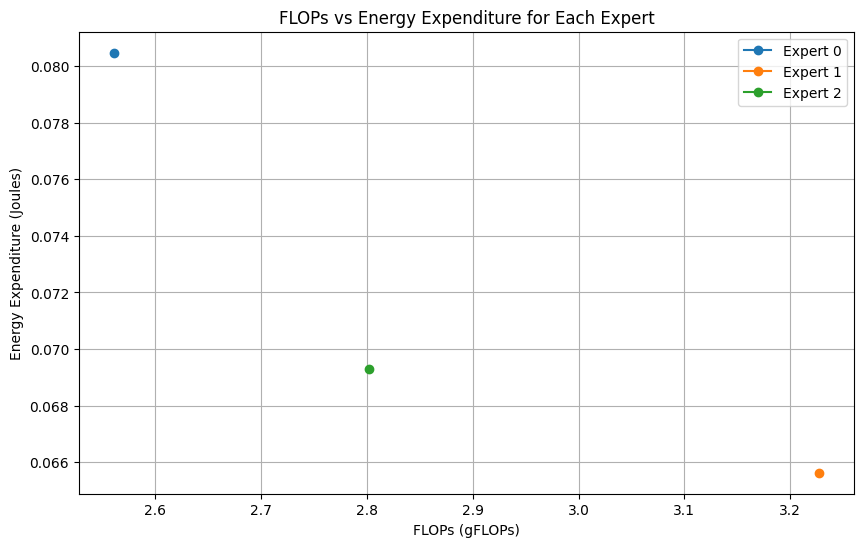

Layer 7 Energy in joules:  18.87083179473877
Layer 1 Gflops: 12.090081990734376
Layer 2 Gflops: 12.09008103706006
Layer 3 Gflops: 12.090080083385743
Layer 4 Gflops: 12.09008103706006
Layer 5 Gflops: 12.09008103706006
Layer 6 Gflops: 12.090081990734376
torch.Size([16, 256, 32000])
Epoch 2/2, Loss: 8.904525756835938


In [6]:
import torch
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import random

# Create DataLoader
batch_size = 16
from torch.nn.utils.rnn import pad_sequence

def perturb_input(input_ids, tokenizer, noise_type="substitution", dropout_prob=0.1, substitution_prob=0.1):
    """
    Perturbs the input tokenized text by applying dropout or substitution noise.

    input_ids: Tensor of shape (batch_size, seq_len)
    tokenizer: The tokenizer used to encode text.
    noise_type: Type of noise ('dropout' or 'substitution')
    dropout_prob: Probability of dropping tokens.
    substitution_prob: Probability of substituting tokens with random tokens.
    """
    batch_size, seq_len = input_ids.size()

    if noise_type == "dropout":
        # Word Dropout: Randomly set some token indices to the pad token
        for i in range(batch_size):
            for j in range(seq_len):
                if random.random() < dropout_prob:
                    input_ids[i, j] = tokenizer.pad_token_id

    elif noise_type == "substitution":
        # Word Substitution: Replace tokens with random tokens from the vocabulary
        vocab_size = tokenizer.vocab_size
        for i in range(batch_size):
            for j in range(seq_len):
                if random.random() < substitution_prob:
                    random_token = random.randint(0, vocab_size - 1)
                    input_ids[i, j] = random_token

    return input_ids


def collate_fn(batch):
    # batch is a list of tensors (each tensor is a tokenized sequence)
    input_ids = [item[0] for item in batch]  # Access the tensor in each batch item

    # Find the maximum length in the batch
    # max_length = max(seq.size(0) for seq in input_ids)
    max_length = 256

    # Pad sequences to the maximum length in the batch
    padded_inputs = torch.stack([
        torch.cat([seq, torch.full((max_length - seq.size(0),), tokenizer.pad_token_id)])
        if seq.size(0) < max_length else seq[:max_length]
        for seq in input_ids
    ], dim=0)

    return {'input_ids': padded_inputs}


# Create DataLoader with custom collate_fn
dataloader = DataLoader(tokenized_data, batch_size=batch_size, shuffle=True,drop_last=True, collate_fn=collate_fn)
print(len(dataloader.dataset))

num_tokens = tokenizer.vocab_size
print("NUM_TOKENS ", num_tokens)
dim = 512
heads = 8
depth = 6  # Number of transformer layers
num_experts = 3 # Number of experts for MoE

# Initialize the SwitchTransformer
model = SwitchTransformer(num_tokens=num_tokens, dim=dim, heads=heads, depth=depth, num_experts=num_experts)

# Use CrossEntropyLoss for token prediction tasks
criterion = torch.nn.CrossEntropyLoss()

# Define the optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-4)

# If using a learning rate scheduler (optional)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.9)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

num_epochs = 2

for epoch in range(num_epochs):
    model.train()
    total_loss = 0
    batch_flops=0

    for batch in dataloader:


        inputs = batch['input_ids'].to(device)
        # for i in range(inputs.size(0)):
        #     input_text = tokenizer.decode(inputs[i].tolist(), skip_special_tokens=True)
        #     print(f"Input Text before noise: {input_text}")
        inputs = perturb_input(inputs.clone(), tokenizer, noise_type="substitution", substitution_prob=0.1)
        # for i in range(inputs.size(0)):
        #     input_text = tokenizer.decode(inputs[i].tolist(), skip_special_tokens=True)
        #     print(f"Input Text after noise: {input_text}")


        # Forward pass
        optimizer.zero_grad()
        with torch.autograd.profiler.profile(use_cuda=True) as prof:
          outputs, flops = model(inputs)

        batchFlops = sum(flops)/depth
        # The model's output shape is (batch_size, seq_length, num_tokens)
        # shift targets for next-token prediction (language modeling)
        print(outputs.shape)
        logits = outputs[:, :-1, :].contiguous()
        targets = inputs[:, 1:].contiguous()
        loss = criterion(logits.view(-1, num_tokens), targets.view(-1))

        # Backpropagation and optimization
        loss.backward()
        optimizer.step()

        # Update total loss
        total_loss += loss.item()
        #del loss, outputs


            # Extract the most likely token indices for the output
            #top_token_indices = outputs[i].argmax(dim=-1)  # Shape: [seq_length]
            #output_text = tokenizer.decode(top_token_indices.tolist(), skip_special_tokens=True)
            #print(f"Output Text: {output_text}")

    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {total_loss/len(dataloader)}")

    # Step the learning rate scheduler, if any
    scheduler.step()